In [1]:

from model_nesy import NeSyConceptLearner

import torch
print(torch.cuda.is_available())
import torch.nn as nn
from PIL import Image
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import linear_sum_assignment
from collections import defaultdict
import pandas as pd

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:
# 📝 Standard library
import os

# 🧮 Numpy (if needed for dataset indexing logic)
import numpy as np

# 🔥 PyTorch core
import torch
from torch.utils.data import DataLoader, Subset

# 🖼️ Torchvision for datasets and transforms
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# ✅ For model evaluation (if running evaluation code immediately)
from model_nesy import NeSyConceptLearner


In [3]:

model = NeSyConceptLearner(
    n_classes=2, n_slots=10, n_iters=3, n_attr=18, n_set_heads=4, set_transf_hidden=128,
                             category_ids = [3, 6, 8, 10, 17], device='cuda'
)

# ✅ Load saved checkpoint
checkpoint_path = '/workspaces/src/checkpoints/model_task1.pt'  # change to your file
state_dict = torch.load(checkpoint_path, map_location='cuda')

model.load_state_dict(state_dict)
print("✅ Loaded model checkpoint from", checkpoint_path)

# ✅ Force entire model to CUDA
model = model.to('cuda')
# ✅ Use the model for evaluation or inference
model.eval()

log = torch.load("/workspaces/src/slot-attention-clevr-state-145", map_location=torch.device("cuda"))
model.img2state_net.load_state_dict(log['weights'], strict=True)



✅ Loaded model checkpoint from /workspaces/src/checkpoints/model_task1.pt


<All keys matched successfully>

In [5]:
# Paths you provided
task1_test_path = '/workspaces/dataset/case_disjoint_main/test/images/t1'
unconfounded_test_path = '/workspaces/dataset/unconfounded/test/images/t0'


In [6]:
# Replace with your actual dataset root and dataset_type
ROOT_DIR = '/workspaces/dataset'
DATASET_TYPE = 'case_disjoint_main'

train_path_task0 = f"{ROOT_DIR}/{DATASET_TYPE}/train/images/t0"
train_path_task1 = f"{ROOT_DIR}/{DATASET_TYPE}/train/images/t1"

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])  


In [8]:
# Load ImageFolder dataset
traindataset1 = datasets.ImageFolder(root=train_path_task1, transform=transform)

# Create DataLoader
BATCH_SIZE = 64
kwargs = {'num_workers': 0, 'pin_memory': False}

train_loader1 = DataLoader(dataset=traindataset1, batch_size=BATCH_SIZE, shuffle=True, **kwargs)


In [9]:
# Create ImageFolder dataset
dataset_task1 = datasets.ImageFolder(root=task1_test_path, transform=transform)

# Split into positive and negative subsets
positives_task1 = [i for i, (x, y) in enumerate(dataset_task1) if y == 1]
negatives_task1 = [i for i, (x, y) in enumerate(dataset_task1) if y == 0]

dataset_task1_p = torch.utils.data.Subset(dataset_task1, positives_task1)
dataset_task1_n = torch.utils.data.Subset(dataset_task1, negatives_task1)

# Create DataLoaders
batch_size = 64
kwargs = {'num_workers': 0, 'pin_memory': False}

loader_task1_p = DataLoader(dataset=dataset_task1_p, batch_size=batch_size, shuffle=False, **kwargs)
loader_task1_n = DataLoader(dataset=dataset_task1_n, batch_size=batch_size, shuffle=False, **kwargs)


In [10]:
# Create ImageFolder dataset
dataset_unconf = datasets.ImageFolder(root=unconfounded_test_path, transform=transform)

# Split into positive and negative subsets
positives_unconf = [i for i, (x, y) in enumerate(dataset_unconf) if y == 1]
negatives_unconf = [i for i, (x, y) in enumerate(dataset_unconf) if y == 0]

dataset_unconf_p = torch.utils.data.Subset(dataset_unconf, positives_unconf)
dataset_unconf_n = torch.utils.data.Subset(dataset_unconf, negatives_unconf)

# Create DataLoaders
loader_unconf_p = DataLoader(dataset=dataset_unconf_p, batch_size=batch_size, shuffle=False, **kwargs)
loader_unconf_n = DataLoader(dataset=dataset_unconf_n, batch_size=batch_size, shuffle=False, **kwargs)


In [11]:
print("🔬 Task 1 Positive Loader size:", len(loader_task1_p.dataset))
print("🔬 Task 1 Negative Loader size:", len(loader_task1_n.dataset))
print("🔬 Unconfounded Positive Loader size:", len(loader_unconf_p.dataset))
print("🔬 Unconfounded Negative Loader size:", len(loader_unconf_n.dataset))


🔬 Task 1 Positive Loader size: 750
🔬 Task 1 Negative Loader size: 750
🔬 Unconfounded Positive Loader size: 750
🔬 Unconfounded Negative Loader size: 750


In [14]:
# Load your merged slots from each task
merged_task0 = np.load('/workspaces/src/merged_slots_task0.npy')  # shape [n_attr, n_slots]
merged_task1 = np.load('/workspaces/src/merged_slots_task1.npy')
merged_task2 = np.load('/workspaces/src/merged_slots_task2.npy')

print("🔬 Merged slots loaded:", merged_task0.shape)

🔬 Merged slots loaded: (15, 3)


In [15]:


clean_attr_labels = [
    'shape_sphere', 'shape_cube', 'shape_cylinder',
    'size_large', 'size_small',
    'material_rubber', 'material_metal',
    'color_cyan', 'color_blue', 'color_yellow', 'color_purple',
    'color_red', 'color_green', 'color_gray', 'color_brown'
]

tasks = ["task0", "task1"]


/tmp/ipykernel_639551/4094900090.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_diff, x='Difference', y='Attribute', palette="coolwarm", dodge=False)


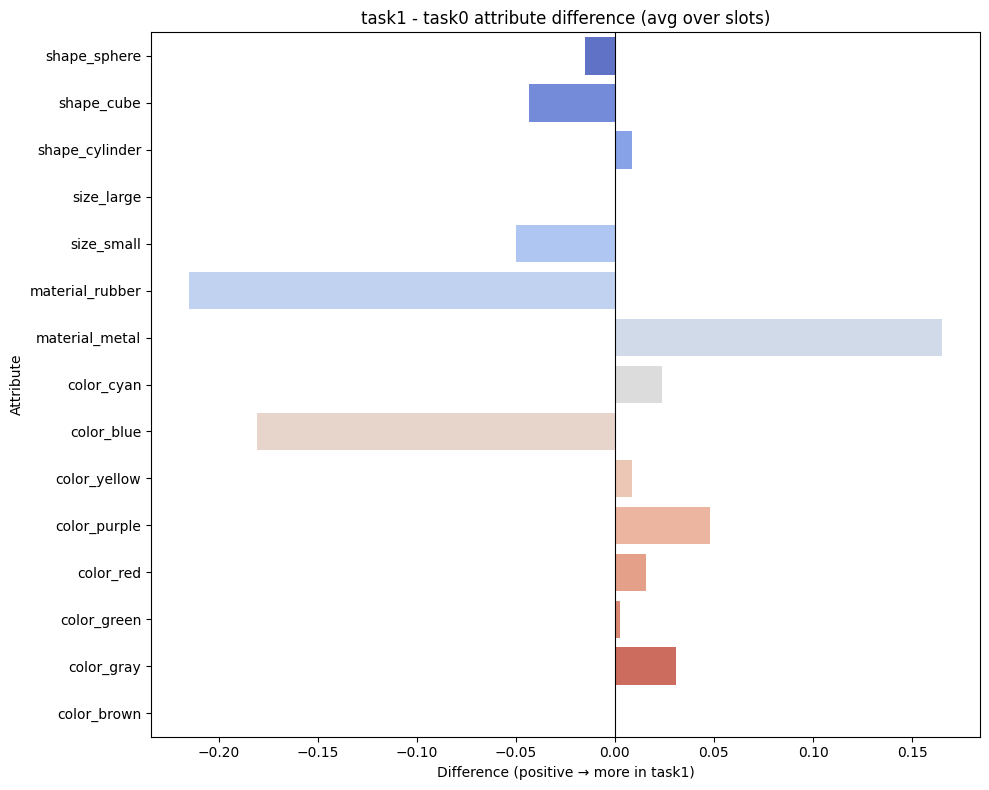

In [16]:
# Build accumulator with clear keys
accumulator = {
    "task0": merged_task0,
    "task1": merged_task1,
    "task2": merged_task2
}

# Define tasks to compare
tasks = [("task0", "task1")]

for task0, task1 in tasks:
    merged_0 = accumulator[task0]  # [n_attr, n_slots]
    merged_1 = accumulator[task1]

    mean_0 = merged_0.mean(axis=1)
    mean_1 = merged_1.mean(axis=1)

    diff = mean_1 - mean_0

    df_diff = pd.DataFrame({
        'Attribute': clean_attr_labels,
        'Difference': diff
    })

    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_diff, x='Difference', y='Attribute', palette="coolwarm", dodge=False)
    plt.title(f"{task1} - {task0} attribute difference (avg over slots)")
    plt.xlabel("Difference (positive → more in task1)")
    plt.ylabel("Attribute")
    plt.axvline(0, color="black", linewidth=0.8)
    plt.tight_layout()
    plt.show()


In [17]:
# Compute difference: task1 - task0
diff = mean_1 - mean_0

# Print out each attribute difference
print("🔬 Attribute differences (task1 - task0):")
for attr, value in zip(clean_attr_labels, diff):
    print(f"{attr}: {value:.4f}")

🔬 Attribute differences (task1 - task0):
shape_sphere: -0.0152
shape_cube: -0.0434
shape_cylinder: 0.0088
size_large: 0.0000
size_small: -0.0498
material_rubber: -0.2150
material_metal: 0.1653
color_cyan: 0.0240
color_blue: -0.1804
color_yellow: 0.0088
color_purple: 0.0480
color_red: 0.0159
color_green: 0.0028
color_gray: 0.0311
color_brown: 0.0000


In [18]:
def evaluate_collect(model, loader_p, loader_n,
                            attr_indices, attr_labels, device):
    """
    Returns:
      acc_p, acc_n, acc_avg,
      sym_p, preds_p,    # lists of [n_attrs, n_slots] arrays + predicted labels
      sym_n, preds_n
    """
    model.eval()
    correct_p = correct_n = 0
    sym_p, preds_p = [], []
    sym_n, preds_n = [], []

    with torch.no_grad():
        for loader, is_pos, correct in [
            (loader_p, True, 0),
            (loader_n, False, 0),
        ]:
            for images, labels in loader:
                images = (images.to(device) - 0.5) * 2
                labels = labels.to(device)

                # 1) Extract slots and transformed attributes
                slots = model.img2state_net(images)
                attrs = model.img2state_net._transform_attrs(slots).detach()

                # 2) Zero out intervened attribute dims
                for idx in attr_indices:
                    attrs[..., idx] = 0

                # 3) Classify
                out = model.set_cls(attrs)
                preds = out.argmax(1)

                # 4) Accuracy
                if is_pos:
                    correct_p += (preds == labels).sum().item()
                else:
                    correct_n += (preds == labels).sum().item()

                # 5) Collect symbolic representation per predicted label
                for i in range(images.size(0)):
                    sym_np = attrs[i].cpu().numpy().T  # [n_attrs, n_slots]
                    pred = int(preds[i].cpu())

                    if pred == 1:
                        sym_p.append(sym_np)
                        preds_p.append(pred)
                    else:
                        sym_n.append(sym_np)
                        preds_n.append(pred)

    acc_p = 100 * correct_p / len(loader_p.dataset)
    acc_n = 100 * correct_n / len(loader_n.dataset)
    acc_avg = 0.5 * (acc_p + acc_n)

    return acc_p, acc_n, acc_avg, sym_p, preds_p, sym_n, preds_n



# —————————————————————————————————————————————
# 2) clean + match utilities (as you already wrote)
# —————————————————————————————————————————————

def clean_symbolic_matrix(symbolic_np, attr_labels):
    # … your existing cleaning code …
    if symbolic_np.shape[0] == len(attr_labels):
        mat = symbolic_np.copy()
    else:
        mat = symbolic_np.T.copy()

    keep_row_mask = [lab not in ('pos_x','pos_y','pos_z')
                     for lab in attr_labels]
    cleaned_mat = mat[keep_row_mask, :]
    cleaned_labels = [lab for lab,keep in zip(attr_labels, keep_row_mask)
                      if keep]

    active_slot_mask = np.any(cleaned_mat > 0, axis=0)
    final_mat = cleaned_mat[:, active_slot_mask]
    slot_indices = np.where(active_slot_mask)[0]
    return final_mat, cleaned_labels, slot_indices


def match_slots(new_slots, ref_slots, cleaned_labels, threshold=0.5):
    """
    new_slots:   [n_attr, n_slots_new] 
    ref_slots:   [n_attr, n_slots_ref]
    cleaned_labels: list of length n_attr
    """
    # only group‐relevant rows (e.g. shape_, size_, material_, color_)
    rows = [i for i,lab in enumerate(cleaned_labels)
            if lab.startswith(('shape_','size_','material_','color_'))]
    A = ref_slots[rows, :]
    B = new_slots[rows, :]

    # Hungarian on negative similarity
    cost = - A.T.dot(B)
    row_ind, col_ind = linear_sum_assignment(cost)
    sim = -cost[row_ind, col_ind]

    # keep only high‐similarity matches
    valid = sim >= threshold
    row_ind = row_ind[valid]
    col_ind = col_ind[valid]

    aligned = np.zeros_like(ref_slots)
    # place each new_slots[:,col] into aligned[:,row]
    aligned[:, row_ind] = new_slots[:, col_ind]
    return aligned

# —————————————————————————————————————————————
# 3) prototype builder: pad & average a list of aligned slot‐matrices
# —————————————————————————————————————————————

def build_prototype(aligned_list):
    # each element is [n_attrs, n_slots]
    max_slots = max(m.shape[1] for m in aligned_list)
    padded = []
    for m in aligned_list:
        if m.shape[1]<max_slots:
            pad = np.zeros((m.shape[0], max_slots-m.shape[1]))
            m = np.concatenate([m,pad],axis=1)
        padded.append(m)
    return np.mean(np.stack(padded),axis=0)   # [n_attrs, max_slots]

# —————————————————————————————————————————————
# 4) two‐panel heatmap plot
# —————————————————————————————————————————————

def plot_case_comparison(task, merged_matrices, clean_attr_labels):
    """
    merged_matrices : list of 2D np.arrays, all with same n_attrs × n_slots
    clean_attr_labels: list of length n_attrs
    """
    n_cases = len(merged_matrices)
    fig, axes = plt.subplots(1, n_cases, figsize=(4*n_cases, 6), squeeze=False)
    for i, (merged, ax) in enumerate(zip(merged_matrices, axes[0])):
        n_slots = merged.shape[1]
        slot_names = [f"slot_{j+1}" for j in range(n_slots)]

        sns.heatmap(
            merged,
            cmap="viridis",
            annot=True,
            cbar=True,
            ax=ax,
            xticklabels=slot_names,
            yticklabels=clean_attr_labels,
            fmt=".2f"
        )
        ax.set_xlabel("Slots")
        ax.set_ylabel("Attributes")
        ax.set_title(f"{task} — case {i}")

    fig.suptitle(f"Slot Attention: {task} — Case Comparison", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [19]:
attr_labels = [
  'pos_x', 'pos_y', 'pos_z',
  'shape_sphere', 'shape_cube', 'shape_cylinder',
  'size_large', 'size_small',          
  'material_rubber', 'material_metal', 
  'color_cyan', 'color_blue', 'color_yellow', 'color_purple',
  'color_red', 'color_green', 'color_gray', 'color_brown'  
]
def extract_prediction_attrs(attrs, preds):
    sym_pos, sym_neg = [], []
    for i in range(attrs.shape[0]):
        sym_np = attrs[i].cpu().numpy().T  # [n_attrs, n_slots]
        if preds[i].item() == 1:
            sym_pos.append(sym_np)
        else:
            sym_neg.append(sym_np)
    return sym_pos, sym_neg


In [20]:
def train_epoch(model, train_loader, attr_indices, attr_labels, optimizer, criterion, device):
    model.set_cls.train()
    train_correct, train_loss, counter = 0, 0.0, 0
    sym_p, sym_n = [], []
    torch.set_grad_enabled(True)

    for _, (image, labels) in enumerate(train_loader):
        counter += 1
        image, labels = image.to(device), labels.to(device)
        image = (image - 0.5) * 2.0
        optimizer.zero_grad()

        attrs = model.img2state_net(image)
        attrs_trans = model.img2state_net._transform_attrs(attrs).detach()

        if attrs_trans.shape[2] != len(attr_labels):
            print(f"⚠️  Train attr count mismatch: {attrs_trans.shape[2]} vs {len(attr_labels)}")
            continue

        for idx in attr_indices:
            attrs_trans[:, :, idx] = 0

        outputs = model.set_cls(attrs_trans)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

        # collect symbolic attrs by prediction
        pos_attrs, neg_attrs = extract_prediction_attrs(attrs_trans, preds)
        sym_p.extend(pos_attrs)
        sym_n.extend(neg_attrs)

    avg_train_loss = train_loss / counter
    train_acc = 100. * (train_correct / len(train_loader.dataset))
    return avg_train_loss, train_acc, sym_p, sym_n


def validate(model, val_loader_p, val_loader_n, attr_indices, attr_labels, device):
    model.set_cls.eval()
    correct_p, correct_n = 0, 0
    sym_p, sym_n = [], []
    torch.set_grad_enabled(False)

    for loader, sym_list in [(val_loader_p, sym_p), (val_loader_n, sym_n)]:
        for image, labels in loader:
            image, labels = image.to(device), labels.to(device)
            image = (image - 0.5) * 2.0
            attrs = model.img2state_net(image)
            attrs_trans = model.img2state_net._transform_attrs(attrs)
            if attrs_trans.shape[2] != len(attr_labels):
                continue
            for idx in attr_indices:
                attrs_trans[:, :, idx] = 0
            outputs = model.set_cls(attrs_trans)
            _, preds = torch.max(outputs.data, 1)

            correct = (preds == labels).sum().item()
            if loader is val_loader_p:
                correct_p += correct
            else:
                correct_n += correct

            pos_attrs, neg_attrs = extract_prediction_attrs(attrs_trans, preds)
            sym_p.extend(pos_attrs)
            sym_n.extend(neg_attrs)

    acc_p = 100. * correct_p / len(val_loader_p.dataset)
    acc_n = 100. * correct_n / len(val_loader_n.dataset)
    avg_val_acc = (acc_p + acc_n) / 2
    return acc_p, acc_n, avg_val_acc, sym_p, sym_n



In [21]:
def evaluate_unconf(model, unconf_test_loader_p, unconf_test_loader_n, attr_indices, attr_labels, device):
    model.set_cls.eval()
    correct_p, correct_n = 0, 0
    sym_p, sym_n = [], []

    with torch.no_grad():
        for loader, sym_list in [(unconf_test_loader_p, sym_p), (unconf_test_loader_n, sym_n)]:
            for image, labels in loader:
                image, labels = image.to(device), labels.to(device)
                image = (image - 0.5) * 2.0
                attrs = model.img2state_net(image)
                attrs_trans = model.img2state_net._transform_attrs(attrs)
                if attrs_trans.shape[2] != len(attr_labels):
                    continue
                for idx in attr_indices:
                    attrs_trans[:, :, idx] = 0
                outputs = model.set_cls(attrs_trans)
                _, preds = torch.max(outputs.data, 1)

                correct = (preds == labels).sum().item()
                if loader is unconf_test_loader_p:
                    correct_p += correct
                else:
                    correct_n += correct

                pos_attrs, neg_attrs = extract_prediction_attrs(attrs_trans, preds)
                sym_p.extend(pos_attrs)
                sym_n.extend(neg_attrs)

    acc_p = 100. * correct_p / len(unconf_test_loader_p.dataset)
    acc_n = 100. * correct_n / len(unconf_test_loader_n.dataset)
    acc_avg = (acc_p + acc_n) / 2
    return acc_p, acc_n, acc_avg, sym_p, sym_n


def evaluate_test(model, test_loader_p, test_loader_n, attr_indices, attr_labels, device):
    model.set_cls.eval()
    correct_p, correct_n = 0, 0
    sym_p, sym_n = [], []

    with torch.no_grad():
        for loader, sym_list in [(test_loader_p, sym_p), (test_loader_n, sym_n)]:
            for image, labels in loader:
                image, labels = image.to(device), labels.to(device)
                image = (image - 0.5) * 2.0
                attrs = model.img2state_net(image)
                attrs_trans = model.img2state_net._transform_attrs(attrs)
                if attrs_trans.shape[2] != len(attr_labels):
                    continue
                for idx in attr_indices:
                    attrs_trans[:, :, idx] = 0
                outputs = model.set_cls(attrs_trans)
                _, preds = torch.max(outputs.data, 1)

                correct = (preds == labels).sum().item()
                if loader is test_loader_p:
                    correct_p += correct
                else:
                    correct_n += correct

                pos_attrs, neg_attrs = extract_prediction_attrs(attrs_trans, preds)
                sym_p.extend(pos_attrs)
                sym_n.extend(neg_attrs)

    acc_p = 100. * correct_p / len(test_loader_p.dataset)
    acc_n = 100. * correct_n / len(test_loader_n.dataset)
    acc_avg = (acc_p + acc_n) / 2
    return acc_p, acc_n, acc_avg, sym_p, sym_n

In [22]:


def train_val_test_save_per_named_interventions(
    model_class,
    checkpoint_path,
    slot_attention_weights_path,
    train_loader,
    val_loader_p, val_loader_n,
    test_loader_p, test_loader_n,
    unconf_loader_p, unconf_loader_n,
    optimizer_class,
    criterion,
    attr_labels,
    intervention_maps,
    device='cuda',
    epochs=10,
    lr=1e-3,
    save_dir='./models'
):
    os.makedirs(save_dir, exist_ok=True)
    results_all = {}

    for map_idx, attr_names in enumerate(intervention_maps):
        # → build intervention tag & index list
        attr_names = sorted(attr_names)
        attr_indices = [attr_labels.index(a) for a in attr_names]
        tag = f"map{map_idx}_" + "_".join(attr_names)

        # → instantiate & load weights
        model = model_class().to(device)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        sa_w = torch.load(slot_attention_weights_path, map_location=device)
        model.img2state_net.load_state_dict(sa_w['weights'])
        model.img2state_net.eval()

        # → only train the classifier head
        optimizer = optimizer_class(
            [p for n,p in model.named_parameters() if 'set_cls' in n and p.requires_grad],
            lr=lr
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

        # —– initialize logs —–
        train_acc_list, train_loss_list = [], []
        train_acc_stepwise = []
        val_acc_list = []
        unconf_epochwise, unconf_stepwise = [], []

        # per-sample lists
        sym_train_p, sym_train_n = [], []
        sym_val_p,   sym_val_n   = [], []
        sym_test_p,  sym_test_n  = [], []
        sym_un_e_p,  sym_un_e_n  = [], []
        sym_un_s_p,  sym_un_s_n  = [], []

        preds_train_p, preds_train_n = [], []
        preds_val_p,   preds_val_n   = [], []
        preds_test_p,  preds_test_n  = [], []
        preds_un_e_p,  preds_un_e_n  = [], []
        preds_un_s_p,  preds_un_s_n  = [], []

        total_images = 0
        running_correct = 0

        for epoch in range(epochs):
            # — training epoch —
            model.set_cls.train()
            epoch_loss = 0
            epoch_correct = 0
            epoch_count = 0

            for images, labels in train_loader:
                images = (images.to(device) - 0.5)*2.0
                labels = labels.to(device)
                optimizer.zero_grad()

                slots = model.img2state_net(images)
                attrs = model.img2state_net._transform_attrs(slots).detach()  # [B,S,A]
                # zero out
                for idx in attr_indices:
                    attrs[:,:,idx] = 0
                if total_images == 0 and epoch == 0:
                                        # also run unconf stepwise
                    u_p, u_n, u_avg, sp, pp, sn, pn = evaluate_collect(
                        model, unconf_loader_p, unconf_loader_n,
                        attr_indices, attr_labels, device
                    )
                    unconf_stepwise.append({
                        'images': total_images,
                        'acc_p':u_p, 'acc_n':u_n, 'acc_avg':u_avg
                    })
                 
                out = model.set_cls(attrs)
                loss = criterion(out, labels)
                loss.backward(); optimizer.step()

                preds = out.argmax(dim=1)
                batch_correct = (preds==labels).sum().item()
                epoch_correct += batch_correct
                epoch_loss += loss.item()
                epoch_count += 1

                # → per-sample collect for train
                for i in range(images.size(0)):
                    mat = attrs[i].cpu().numpy().T
                    if preds[i]==1:
                        sym_train_p.append(mat); preds_train_p.append(1)
                    else:
                        sym_train_n.append(mat); preds_train_n.append(0)

                # → stepwise train acc every 100 images
                total_images += images.size(0)
                running_correct += batch_correct
                if total_images % 100 == 0:
                    train_acc_stepwise.append({
                        'images': total_images,
                        'acc': 100*running_correct/total_images
                    })
                    # also run unconf stepwise
                    u_p, u_n, u_avg, sp, pp, sn, pn = evaluate_collect(
                        model, unconf_loader_p, unconf_loader_n,
                        attr_indices, attr_labels, device
                    )
                    unconf_stepwise.append({
                        'images': total_images,
                        'acc_p':u_p, 'acc_n':u_n, 'acc_avg':u_avg
                    })
                    sym_un_s_p.extend(sp); preds_un_s_p.extend(pp)
                    sym_un_s_n.extend(sn); preds_un_s_n.extend(pn)

            # — scheduler & epoch logs —
            scheduler.step()
            avg_loss = epoch_loss/epoch_count
            train_acc = 100*epoch_correct/len(train_loader.dataset)
            train_loss_list.append(avg_loss)
            train_acc_list.append(train_acc)

            # — validation, epochwise —
            v_p, v_n, v_avg, sp, pp, sn, pn = evaluate_collect(
                model, val_loader_p, val_loader_n,
                attr_indices, attr_labels, device
            )
            val_acc_list.append({
                'epoch': epoch+1,
                'acc_p':v_p, 'acc_n':v_n, 'acc_avg':v_avg
            })
            sym_val_p.extend(sp); preds_val_p.extend(pp)
            sym_val_n.extend(sn); preds_val_n.extend(pn)

            print(f"[{tag}] Epoch {epoch+1}/{epochs} → Train {train_acc:.2f}%  Val {v_avg:.2f}%")

            # — unconfounded, epochwise —
            u_p, u_n, u_avg, sp, pp, sn, pn = evaluate_collect(
                model, unconf_loader_p, unconf_loader_n,
                attr_indices, attr_labels, device
            )
            unconf_epochwise.append({
                'epoch': epoch+1,
                'acc_p':u_p, 'acc_n':u_n, 'acc_avg':u_avg
            })
            sym_un_e_p.extend(sp); preds_un_e_p.extend(pp)
            sym_un_e_n.extend(sn); preds_un_e_n.extend(pn)
            print(f"🧪 Unconf Test Acc (Epoch {epoch+1}) → Pos: {u_p:.2f}%, Neg: {u_n:.2f}%, Avg: {u_avg:.2f}%")
        # — final test —
        t_p, t_n, t_avg, sp, pp, sn, pn = evaluate_collect(
            model, test_loader_p, test_loader_n,
            attr_indices, attr_labels, device
        )
        sym_test_p.extend(sp); preds_test_p.extend(pp)
        sym_test_n.extend(sn); preds_test_n.extend(pn)
        print(f"[{tag}] FINAL test → Pos {t_p:.2f}%, Neg {t_n:.2f}%, Avg {t_avg:.2f}%")

        base_name = os.path.basename(checkpoint_path)
        task_name = base_name.replace("model_", "").replace(".pt", "")
        attr_tag = "_".join(attr_names)
        save_path = os.path.join(save_dir, f"model_{task_name}_{attr_tag}.pt")
        torch.save(model.state_dict(), save_path)
        print(f"💾 Saved model → {save_path}")

        # — package results —
        results_all[tag] = {
            'train_acc': train_acc_list,
            'train_loss': train_loss_list,
            'train_acc_stepwise': train_acc_stepwise,
            'val_acc': val_acc_list,
            'unconf_epochwise': unconf_epochwise,
            'unconf_stepwise': unconf_stepwise,
            'test_acc': t_avg,
            'symb': {
                'train_p': sym_train_p, 'train_n': sym_train_n,
                'val_p': sym_val_p,     'val_n': sym_val_n,
                'test_p': sym_test_p,   'test_n': sym_test_n,
                'unconf_ep_p': sym_un_e_p, 'unconf_ep_n': sym_un_e_n,
                'unconf_st_p': sym_un_s_p, 'unconf_st_n': sym_un_s_n,
            },
            'preds': {
              'train_p': preds_train_p, 'train_n': preds_train_n,
              'val_p': preds_val_p,     'val_n': preds_val_n,
              'test_p': preds_test_p,   'test_n': preds_test_n,
              'unconf_ep_p': preds_un_e_p, 'unconf_ep_n': preds_un_e_n,
              'unconf_st_p': preds_un_s_p, 'unconf_st_n': preds_un_s_n,
            }
        }

    return results_all


In [23]:
def create_task_loaders(task_train_path, task_val_path, task_test_path, batch_size=64, img_size=(128,128)):
    """
    Creates train, val, and test DataLoaders (with positive and negative splits) for a given task dataset.

    Args:
        task_train_path: path to training images folder
        task_val_path: path to validation images folder
        task_test_path: path to test images folder
        batch_size: batch size for DataLoader
        img_size: tuple (H,W) for image resizing

    Returns:
        train_loader, val_loader_p, val_loader_n, test_loader_p, test_loader_n
    """

    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])

    kwargs = {'num_workers': 0, 'pin_memory': False}

    # 🔧 Train loader (no positive/negative split needed for training)
    dataset_train = datasets.ImageFolder(root=task_train_path, transform=transform)
    train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, **kwargs)

    # 🔧 Validation loader (split positive and negative)
    dataset_val = datasets.ImageFolder(root=task_val_path, transform=transform)
    positives_val = [i for i, (_, y) in enumerate(dataset_val) if y == 1]
    negatives_val = [i for i, (_, y) in enumerate(dataset_val) if y == 0]
    dataset_val_p = Subset(dataset_val, positives_val)
    dataset_val_n = Subset(dataset_val, negatives_val)
    val_loader_p = DataLoader(dataset=dataset_val_p, batch_size=batch_size, shuffle=False, **kwargs)
    val_loader_n = DataLoader(dataset=dataset_val_n, batch_size=batch_size, shuffle=False, **kwargs)

    # 🔧 Test loader (split positive and negative)
    dataset_test = datasets.ImageFolder(root=task_test_path, transform=transform)
    positives_test = [i for i, (_, y) in enumerate(dataset_test) if y == 1]
    negatives_test = [i for i, (_, y) in enumerate(dataset_test) if y == 0]
    dataset_test_p = Subset(dataset_test, positives_test)
    dataset_test_n = Subset(dataset_test, negatives_test)
    test_loader_p = DataLoader(dataset=dataset_test_p, batch_size=batch_size, shuffle=False, **kwargs)
    test_loader_n = DataLoader(dataset=dataset_test_n, batch_size=batch_size, shuffle=False, **kwargs)

    print(f"✅ Created loaders → Train: {len(dataset_train)}, Val_p: {len(dataset_val_p)}, Val_n: {len(dataset_val_n)}, Test_p: {len(dataset_test_p)}, Test_n: {len(dataset_test_n)}")

    return train_loader, val_loader_p, val_loader_n, test_loader_p, test_loader_n

In [24]:
task0_train_path = "/workspaces/dataset/case_disjoint_main/train/images/t0"
task1_train_path = "/workspaces/dataset/case_disjoint_main/train/images/t1"
task2_train_path = "/workspaces/dataset/case_disjoint_main/train/images/t2"

task0_val_path = "/workspaces/dataset/case_disjoint_main/val/images/t0"
task1_val_path = "/workspaces/dataset/case_disjoint_main/val/images/t1"
task2_val_path = "/workspaces/dataset/case_disjoint_main/val/images/t2"

task0_test_path = "/workspaces/dataset/case_disjoint_main/test/images/t0"
task1_test_path = "/workspaces/dataset/case_disjoint_main/test/images/t1"
task2_test_path = "/workspaces/dataset/case_disjoint_main/test/images/t2"


In [25]:
# Load each task separately
train_loader0, val_loader0_p, val_loader0_n, test_loader0_p, test_loader0_n = create_task_loaders(
    task0_train_path, task0_val_path, task0_test_path,
    batch_size=64, img_size=(128,128)
)

train_loader1, val_loader1_p, val_loader1_n, test_loader1_p, test_loader1_n = create_task_loaders(
    task1_train_path, task1_val_path, task1_test_path,
    batch_size=64, img_size=(128,128)
)

train_loader2, val_loader2_p, val_loader2_n, test_loader2_p, test_loader2_n = create_task_loaders(
    task2_train_path, task2_val_path, task2_test_path,
    batch_size=64, img_size=(128,128)
)


✅ Created loaders → Train: 6000, Val_p: 750, Val_n: 750, Test_p: 750, Test_n: 750
✅ Created loaders → Train: 6000, Val_p: 750, Val_n: 750, Test_p: 750, Test_n: 750
✅ Created loaders → Train: 6000, Val_p: 750, Val_n: 750, Test_p: 750, Test_n: 750


In [26]:
from torch.utils.data import ConcatDataset, DataLoader

# Combine datasets
train_dataset0 = train_loader0.dataset
train_dataset1 = train_loader1.dataset
train_dataset2 = train_loader2.dataset
    
# Task 0: only task 0
train_loader_t0 = train_loader0

# Task 1: task 0 + task 1
train_dataset_01 = ConcatDataset([train_dataset0, train_dataset1])
train_loader_t1 = DataLoader(train_dataset_01, batch_size=64, shuffle=True)

# Task 2: task 0 + task 1 + task 2
train_dataset_012 = ConcatDataset([train_dataset0, train_dataset1, train_dataset2])
train_loader_t2 = DataLoader(train_dataset_012, batch_size=64, shuffle=True)


In [27]:
# Task 1 val
val_dataset0_p = val_loader0_p.dataset
val_loader0_p = DataLoader(val_dataset0_p, batch_size=64, shuffle=False)
val_dataset1_p = val_loader1_p.dataset
val_dataset_01_p = ConcatDataset([val_dataset0_p, val_dataset1_p])
val_loader_t1_p = DataLoader(val_dataset_01_p, batch_size=64, shuffle=False)

val_dataset0_n = val_loader0_n.dataset
val_loader0_n = DataLoader(val_dataset0_n, batch_size=64, shuffle=False)
val_dataset1_n = val_loader1_n.dataset
val_dataset_01_n = ConcatDataset([val_dataset0_n, val_dataset1_n])
val_loader_t1_n = DataLoader(val_dataset_01_n, batch_size=64, shuffle=False)

# Task 2 val (Positive)
val_dataset2_p = val_loader2_p.dataset
val_dataset_02_p = ConcatDataset([val_dataset0_p, val_dataset1_p, val_dataset2_p])
val_loader_t2_p = DataLoader(val_dataset_02_p, batch_size=64, shuffle=False)

# Task 2 val (Negative)
val_dataset2_n = val_loader2_n.dataset
val_dataset_02_n = ConcatDataset([val_dataset0_n, val_dataset1_n, val_dataset2_n])
val_loader_t2_n = DataLoader(val_dataset_02_n, batch_size=64, shuffle=False)

In [28]:
model_class = lambda: NeSyConceptLearner(
    n_classes=2,
    n_slots=10,
    n_iters=3,
    n_attr=18,
    n_set_heads=4,
    set_transf_hidden=128,
    category_ids=[3, 6, 8, 10, 17],
    device='cuda'
)
criterion = nn.CrossEntropyLoss()

[ 0.02012712 -0.02295208  0.0144774   0.09392656 -0.08227408  0.07944912
 -0.06779661  0.02118644 -0.05190678  0.01094632 -0.02259887  0.01165254
  0.02401131  0.01836157  0.        ]


/tmp/ipykernel_639551/1790377734.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_diff, x='Difference', y='Attribute', palette="coolwarm", dodge=False)


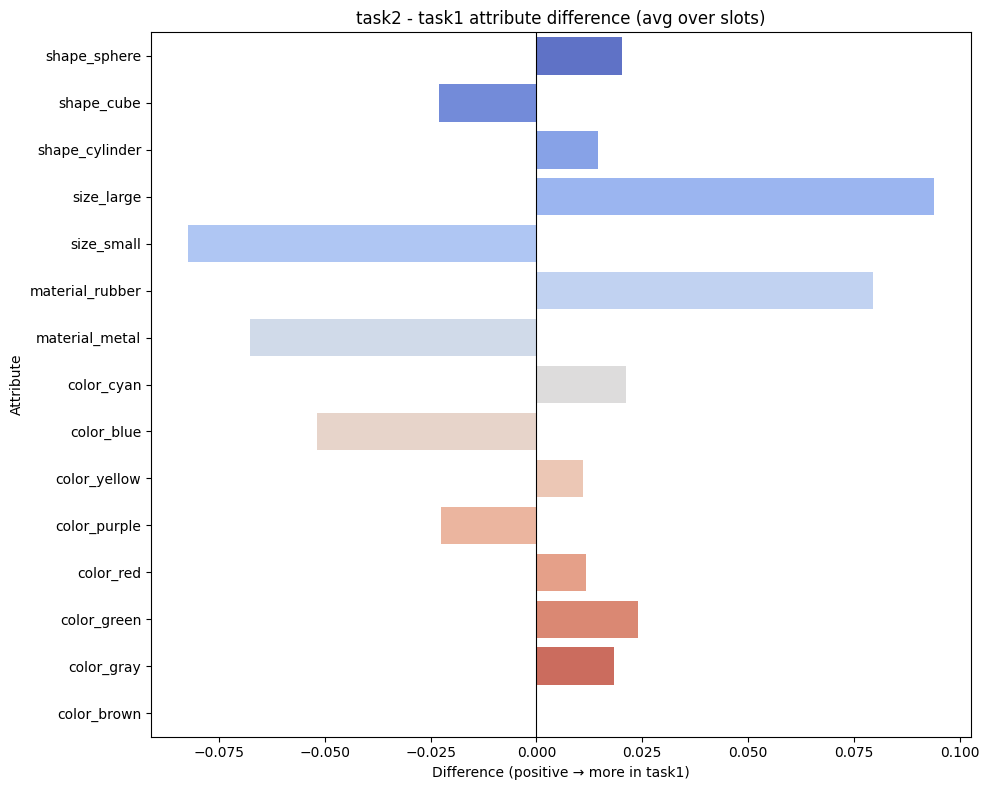

In [32]:
# ✅ Average across slots to get per-attribute values
avg_task1 = merged_task1.mean(axis=1)
avg_task2 = merged_task2.mean(axis=1)

# ✅ Compute difference
diff_t2_minus_t1 = avg_task2 - avg_task1
print(diff_t2_minus_t1)

df_diff = pd.DataFrame({
        'Attribute': clean_attr_labels,
        'Difference': diff_t2_minus_t1
})

plt.figure(figsize=(10, 8))
sns.barplot(data=df_diff, x='Difference', y='Attribute', palette="coolwarm", dodge=False)
plt.title("task2 - task1 attribute difference (avg over slots)")
plt.xlabel("Difference (positive → more in task1)")
plt.ylabel("Attribute")
plt.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()



In [33]:
attr_labels = [
  'pos_x', 'pos_y', 'pos_z',
  'shape_sphere', 'shape_cube', 'shape_cylinder',
  'size_large', 'size_small',          
  'material_rubber', 'material_metal', 
  'color_cyan', 'color_blue', 'color_yellow', 'color_purple',
  'color_red', 'color_green', 'color_gray', 'color_brown'  
]

# )

In [ ]:
#    3) prepare your intervention maps:
intervention_maps = [
    ['color_blue','material_metal','size_large','shape_cube','size_small','shape_sphere','material_rubber'],
    ['color_blue', 'material_metal','material_rubber']
]

# intervention_maps = [[attr] for attr in attr_labels]

res_0 = train_val_test_save_per_named_interventions(
    model_class=model_class,
    checkpoint_path="/workspaces/src/checkpoints/model_task1.pt",
    slot_attention_weights_path="/workspaces/src/slot-attention-clevr-state-145",
    train_loader=train_loader_t0,
    val_loader_p=val_loader0_p,
    val_loader_n=val_loader0_n,
    test_loader_p=test_loader0_p,
    test_loader_n=test_loader0_n,
    unconf_loader_p =  loader_unconf_p,
    unconf_loader_n = loader_unconf_n,
    optimizer_class=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    attr_labels=attr_labels,
    intervention_maps=intervention_maps,
    device='cuda',
    epochs=10,
    lr=0.001,
    save_dir='./models_test1'
)

In [39]:
intervention_maps = [
    ['color_blue','material_metal','size_large','shape_cube','size_small','shape_sphere','material_rubber'],
    ['color_blue', 'material_metal','material_rubber'],
    ['color_blue', 'material_metal']
]


res_1_1 = train_val_test_save_per_named_interventions(
    model_class=model_class,
    checkpoint_path="/workspaces/src/checkpoints/model_task1.pt",
    slot_attention_weights_path="/workspaces/src/slot-attention-clevr-state-145",
    train_loader=train_loader_t1,
    val_loader_p=val_loader_t1_p,
    val_loader_n=val_loader_t1_n,
    test_loader_p=test_loader1_p,
    test_loader_n=test_loader1_n,
    unconf_loader_p =  loader_unconf_p,
    unconf_loader_n = loader_unconf_n,
    optimizer_class=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    attr_labels=attr_labels,
    intervention_maps=intervention_maps,
    device='cuda',
    epochs=10,
    lr=0.001,
    save_dir='./models_test1_1'
)



[map0_color_blue_material_metal_material_rubber_shape_cube_shape_sphere_size_large_size_small] Epoch 1/10 → Train 73.81%  Val 75.30%
🧪 Unconf Test Acc (Epoch 1) → Pos: 51.33%, Neg: 59.47%, Avg: 55.40%
[map0_color_blue_material_metal_material_rubber_shape_cube_shape_sphere_size_large_size_small] Epoch 2/10 → Train 76.92%  Val 76.23%
🧪 Unconf Test Acc (Epoch 2) → Pos: 45.87%, Neg: 62.27%, Avg: 54.07%
[map0_color_blue_material_metal_material_rubber_shape_cube_shape_sphere_size_large_size_small] Epoch 3/10 → Train 76.69%  Val 76.10%
🧪 Unconf Test Acc (Epoch 3) → Pos: 44.13%, Neg: 64.00%, Avg: 54.07%
[map0_color_blue_material_metal_material_rubber_shape_cube_shape_sphere_size_large_size_small] Epoch 4/10 → Train 77.45%  Val 76.93%
🧪 Unconf Test Acc (Epoch 4) → Pos: 49.87%, Neg: 59.73%, Avg: 54.80%
[map0_color_blue_material_metal_material_rubber_shape_cube_shape_sphere_size_large_size_small] Epoch 5/10 → Train 77.27%  Val 76.93%
🧪 Unconf Test Acc (Epoch 5) → Pos: 48.67%, Neg: 60.80%, Avg: 54

In [ ]:
intervention_maps_t2 = [
    ['color_blue','material_metal', 'material_rubber', 'size_large', 'size_small'  ],
    ['color_blue','material_metal', 'material_rubber', 'size_large'  ],
]
res_2 = train_val_test_save_per_named_interventions(
    model_class=model_class,
    checkpoint_path="/workspaces/src/train_files/models_test1/model_task1_color_blue_material_metal_material_rubber.pt",
    slot_attention_weights_path="/workspaces/src/slot-attention-clevr-state-145",
    train_loader=train_loader_t2,
    val_loader_p=val_loader_t2_p,
    val_loader_n=val_loader_t2_n,
    test_loader_p=test_loader2_p,
    test_loader_n=test_loader2_n,
    unconf_loader_p =  loader_unconf_p,
    unconf_loader_n = loader_unconf_n,
    optimizer_class=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    attr_labels=attr_labels,
    intervention_maps=intervention_maps_t2,
    device='cuda',
    epochs=10,
    lr=0.001,
    save_dir='./models_test2'
)

[map0_color_blue_material_metal_material_rubber_size_large_size_small] Epoch 1/10 → Train 94.14%  Val 91.84%
[map0_color_blue_material_metal_material_rubber_size_large_size_small] Epoch 2/10 → Train 94.52%  Val 94.53%
[map0_color_blue_material_metal_material_rubber_size_large_size_small] Epoch 3/10 → Train 94.90%  Val 94.20%
[map0_color_blue_material_metal_material_rubber_size_large_size_small] Epoch 4/10 → Train 95.17%  Val 95.22%
[map0_color_blue_material_metal_material_rubber_size_large_size_small] Epoch 5/10 → Train 95.42%  Val 94.73%
[map0_color_blue_material_metal_material_rubber_size_large_size_small] Epoch 6/10 → Train 95.74%  Val 95.11%
[map0_color_blue_material_metal_material_rubber_size_large_size_small] Epoch 7/10 → Train 95.74%  Val 95.07%
[map0_color_blue_material_metal_material_rubber_size_large_size_small] Epoch 8/10 → Train 95.69%  Val 95.24%
[map0_color_blue_material_metal_material_rubber_size_large_size_small] Epoch 9/10 → Train 95.94%  Val 95.42%
[map0_color_blue_ma

In [49]:
def plot_training_results(results_dict):
    for key, val in results_dict.items():
        epochs = list(range(1, len(val['train_acc']) + 1))
        fig, axs = plt.subplots(3, 2, figsize=(14, 12))
        fig.suptitle(f"Intervention: {key}", fontsize=16)
        


        # 1) Train accuracy
        axs[0, 0].plot(epochs, val['train_acc'], label="Train Acc")
        axs[0, 0].set_title("Train Accuracy")
        axs[0, 0].set_xlabel("Epoch")
        axs[0, 0].set_ylabel("Accuracy (%)")
        axs[0, 0].legend()

        # 2) Train loss
        axs[0, 1].plot(epochs, val['train_loss'], label="Train Loss", color="red")
        axs[0, 1].set_title("Train Loss")
        axs[0, 1].set_xlabel("Epoch")
        axs[0, 1].set_ylabel("Loss")
        axs[0, 1].legend()

        # 3) Val accuracy
        if 'val_acc' in val:
            val_epochs = [v["epoch"] for v in val['val_acc']]
            val_avg = [v["acc_avg"] for v in val['val_acc']]
            val_p = [v["acc_p"] for v in val['val_acc']]
            val_n = [v["acc_n"] for v in val['val_acc']]
            axs[1, 0].plot(val_epochs, val_avg, label="Val Avg")
            axs[1, 0].plot(val_epochs, val_p, label="Val Pos", linestyle='--')
            axs[1, 0].plot(val_epochs, val_n, label="Val Neg", linestyle=':')
            axs[1, 0].set_title("Validation Accuracy")
            axs[1, 0].set_xlabel("Epoch")
            axs[1, 0].set_ylabel("Accuracy (%)")
            axs[1, 0].legend()

        # 4) Unconf test per epoch
        if 'unconf_epochwise' in val:
            ue_epochs = [u["epoch"] for u in val['unconf_epochwise']]
            ue_avg = [u["acc_avg"] for u in val['unconf_epochwise']]
            ue_p = [u["acc_p"] for u in val['unconf_epochwise']]
            ue_n = [u["acc_n"] for u in val['unconf_epochwise']]
            axs[1, 1].plot(ue_epochs, ue_avg, label="Unconf Avg")
            axs[1, 1].plot(ue_epochs, ue_p, label="Unconf Pos", linestyle='--')
            axs[1, 1].plot(ue_epochs, ue_n, label="Unconf Neg", linestyle=':')
            axs[1, 1].set_title("Unconf Test Accuracy (per Epoch)")
            axs[1, 1].set_xlabel("Epoch")
            axs[1, 1].set_ylabel("Accuracy (%)")
            axs[1, 1].legend()

        # 5) Unconf test stepwise
        if 'unconf_stepwise' in val:
            steps = [u["images"] for u in val['unconf_stepwise']]
            step_avg = [u["acc_avg"] for u in val['unconf_stepwise']]
            step_p = [u["acc_p"] for u in val['unconf_stepwise']]
            step_n = [u["acc_n"] for u in val['unconf_stepwise']]
            axs[2, 0].plot(steps, step_avg, label="Step Avg")
            axs[2, 0].plot(steps, step_p, label="Step Pos", linestyle='--')
            axs[2, 0].plot(steps, step_n, label="Step Neg", linestyle=':')
            axs[2, 0].set_title("Unconf Test Accuracy (Stepwise)")
            axs[2, 0].set_xlabel("Images Seen")
            axs[2, 0].set_ylabel("Accuracy (%)")
            axs[2, 0].legend()

                # 6) Train Acc Stepwise (image-wise)
        if 'train_acc_stepwise' in val:
            steps = [u["images"] for u in val['train_acc_stepwise']]
            accs = [u["acc"] for u in val['train_acc_stepwise']]
            axs[2, 1].plot(steps, accs, label="Train Acc Stepwise", color='green')
            axs[2, 1].set_title("Train Accuracy (Stepwise)")
            axs[2, 1].set_xlabel("Images Seen")
            axs[2, 1].set_ylabel("Accuracy (%)")
            axs[2, 1].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


In [50]:

def plot_symbolic_prototypes(results, attr_labels):
    case_names = ['train','val','test','unconf_ep','unconf_st']

    for key, r in results.items():
        # 1) gather list of mats per case
        cases = {
            'train':     r['symb']['train_p']     + r['symb']['train_n'],
            'val':       r['symb']['val_p']       + r['symb']['val_n'],
            'test':      r['symb']['test_p']      + r['symb']['test_n'],
            'unconf_ep': r['symb']['unconf_ep_p'] + r['symb']['unconf_ep_n'],
            'unconf_st': r['symb']['unconf_st_p'] + r['symb']['unconf_st_n'],
        }
        preds = {
            name: len(r['preds'][f"{name}_p"]) 
            for name in case_names
        }

        print(f"\n=== Intervention: {key} ===")
        for name in case_names:
            total = len(cases[name])
            p = preds[name]
            print(f"{name:10s} → #mats={total:5d}, #pos={p:5d}, #neg={total-p:5d}")

        # 2) build prototypes
        prototypes = []
        ref = None
        labs = None
        for mats in cases.values():
            cleaned = []
            for mat in mats:
                cm, labs, _ = clean_symbolic_matrix(mat, attr_labels)
                cleaned.append(cm)
            if ref is None:
                ref = cleaned[0]
            aligned = [match_slots(cm, ref, labs) for cm in cleaned]
            prototypes.append(build_prototype(aligned))

        # 3) one‐row 5‐col heatmaps
        fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
        fig.suptitle(f"Symbolic Prototypes for {key}", fontsize=18)
        for i, case in enumerate(case_names):
            ax = axes[i]
            proto = prototypes[i]
            sns.heatmap(proto,
                        cmap="viridis",
                        cbar=(i==4),
                        ax=ax,
                        yticklabels=labs,
                        annot=True,
                        xticklabels=[f"s{j+1}" for j in range(proto.shape[1])])
            ax.set_title(case)
            ax.set_xlabel("Slots")
            if i==0:
                ax.set_ylabel("Attributes")
        plt.tight_layout(rect=[0,0,1,0.92])
        plt.show()


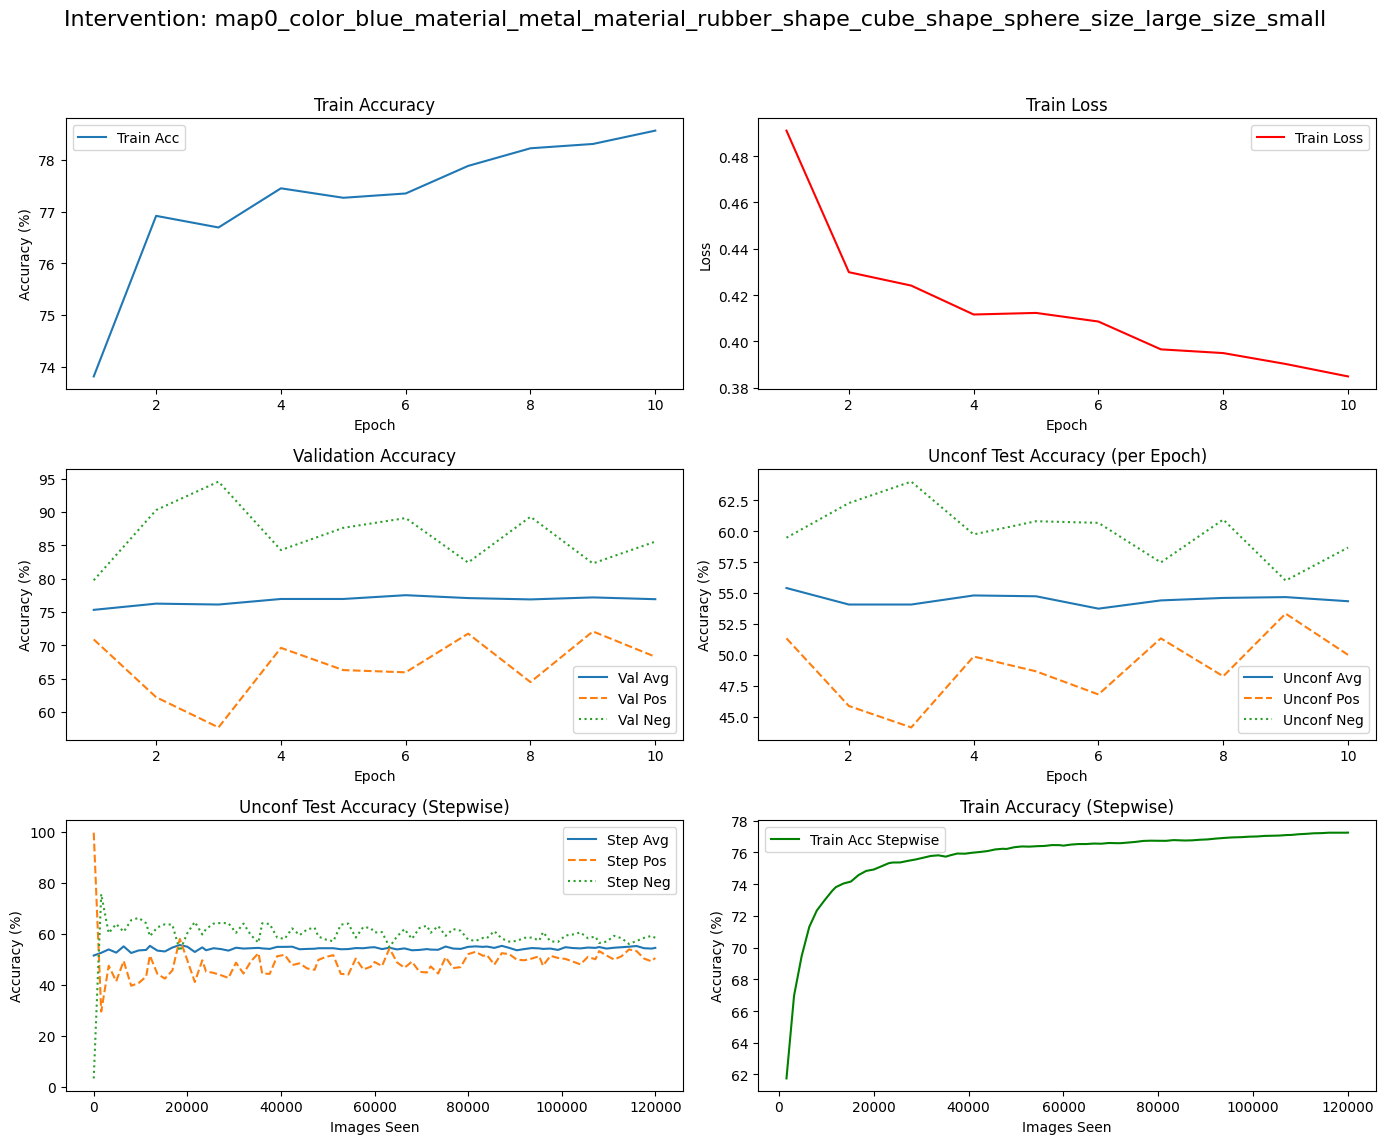

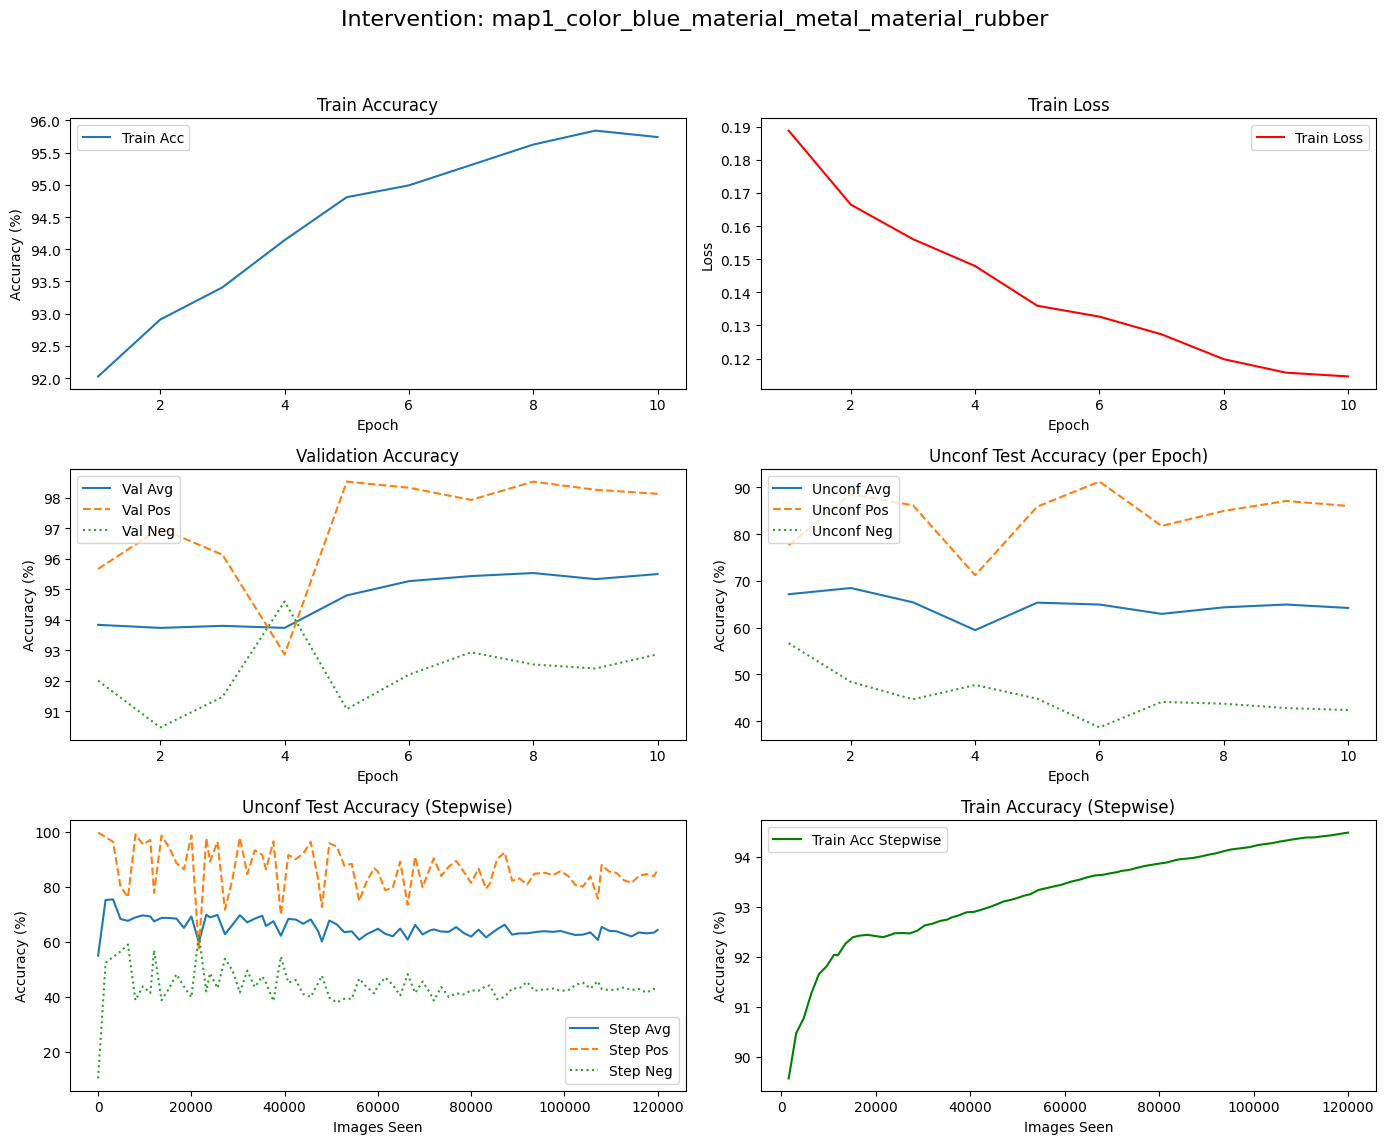

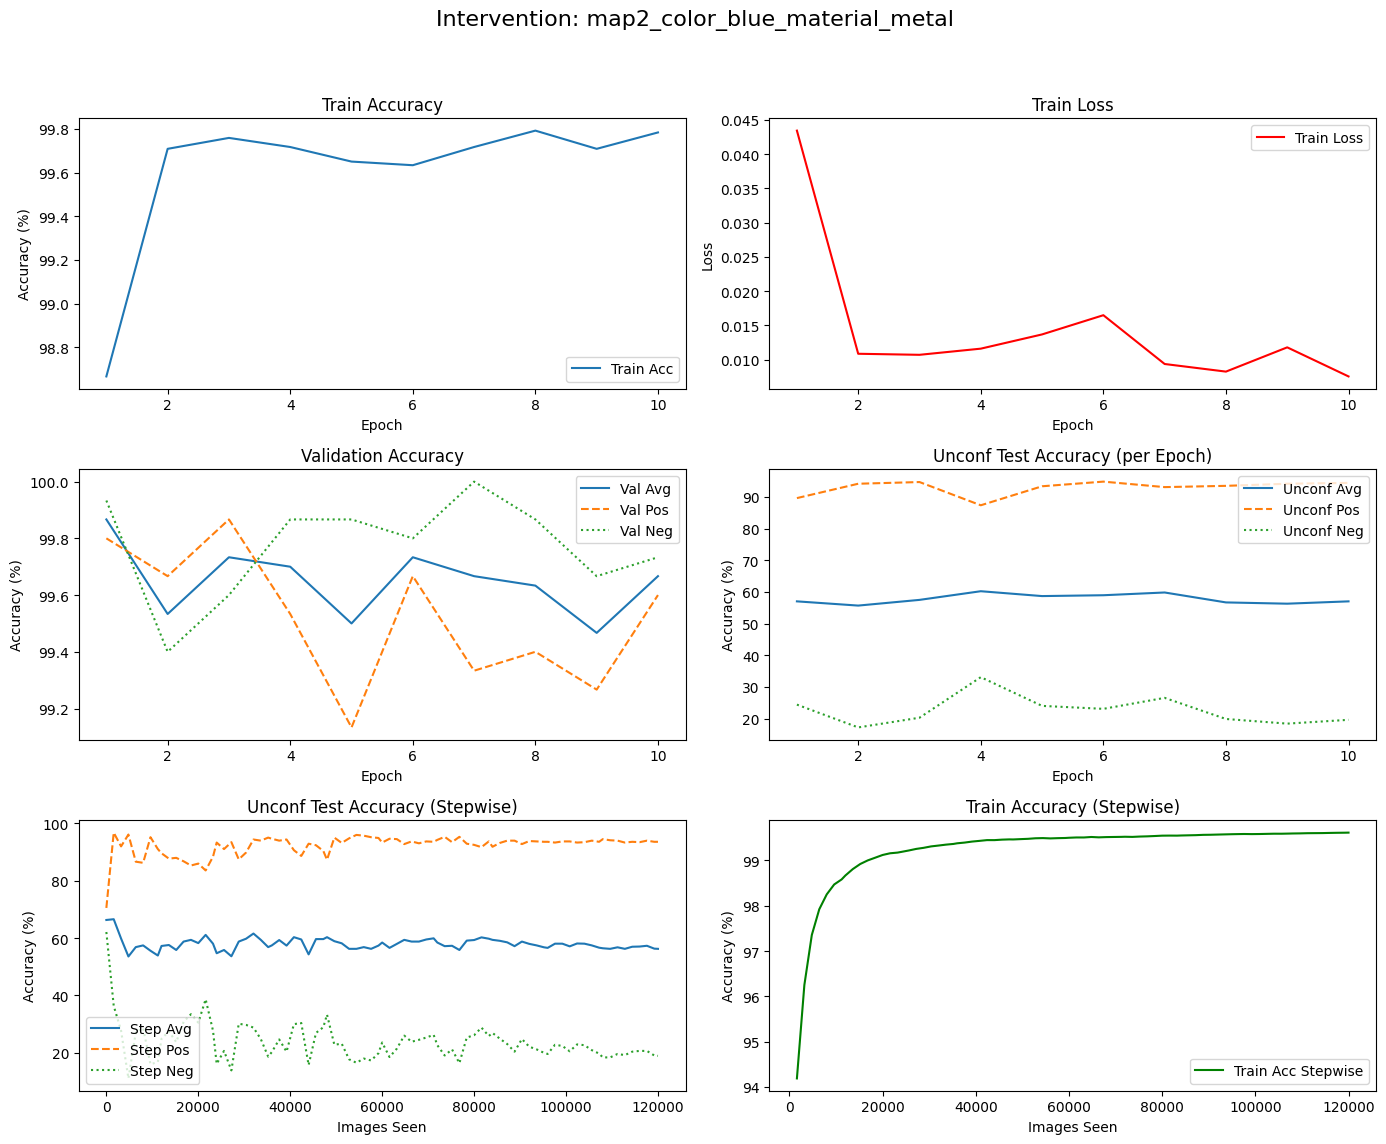

In [51]:
plot_training_results(res_1_1)

In [58]:
import matplotlib.pyplot as plt

def plot_stepwise_zoom(results_dict, frac=0.5):
    """
    Plot only the first frac (default 50%) of unconf_stepwise and train_acc_stepwise accuracy curves.

    Args:
        results_dict: dict, results as output from your training code (one experiment or a single run)
        frac: float, fraction of the curve to show (e.g. 0.5 for first half)
    """
    for key, val in results_dict.items():
        # Unconf Test Stepwise
        if 'unconf_stepwise' in val:
            steps = [u["images"] for u in val['unconf_stepwise']]
            step_avg = [u["acc_avg"] for u in val['unconf_stepwise']]
            step_p = [u["acc_p"] for u in val['unconf_stepwise']]
            step_n = [u["acc_n"] for u in val['unconf_stepwise']]
            cut = int(len(steps) * frac)

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(steps[:cut], step_avg[:cut], label="Step Avg")
            plt.plot(steps[:cut], step_p[:cut], label="Step Pos", linestyle='--')
            plt.plot(steps[:cut], step_n[:cut], label="Step Neg", linestyle=':')
            plt.title("Unconf Test Accuracy (Stepwise )")
            plt.xlabel("Images Seen")
            plt.ylabel("Accuracy (%)")
            plt.legend()

        # Train Acc Stepwise
        if 'train_acc_stepwise' in val:
            steps = [u["images"] for u in val['train_acc_stepwise']]
            accs = [u["acc"] for u in val['train_acc_stepwise']]
            cut = int(len(steps) * frac)

            plt.subplot(1, 2, 2)
            plt.plot(steps[:cut], accs[:cut], label="Train Acc Stepwise", color='green')
            plt.title("Train Accuracy (Stepwise)")
            plt.xlabel("Images Seen")
            plt.ylabel("Accuracy (%)")
            plt.legend()

        plt.suptitle(f"Stepwise Learning Curves  – {key}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
def print_highest_stepwise_acc(results_dict, frac=0.5):
    """
    Prints the highest stepwise average accuracy (unconf_stepwise) for each key in the results dictionary,
    considering only the first frac of the data.
    """
    for key, val in results_dict.items():
        if 'unconf_stepwise' in val:
            step_avg = [u["acc_avg"] for u in val['unconf_stepwise']]
            cut = int(len(step_avg) * frac)
            max_acc = max(step_avg[:cut])
            print(f"{key}: Highest Stepwise Avg Acc (first {int(frac*100)}%) = {max_acc:.2f}%")

# Example usage:
print_highest_stepwise_acc(res_1_1, frac=0.5)


map0_color_blue_material_metal_material_rubber_shape_cube_shape_sphere_size_large_size_small: Highest Stepwise Avg Acc (first 50%) = 55.60%
map1_color_blue_material_metal_material_rubber: Highest Stepwise Avg Acc (first 50%) = 75.33%
map2_color_blue_material_metal: Highest Stepwise Avg Acc (first 50%) = 66.60%


map0_color_blue_material_metal_material_rubber_shape_cube_shape_sphere_size_large_size_small: Highest Stepwise Avg Acc (first 50%) = 55.60%
map1_color_blue_material_metal_material_rubber: Highest Stepwise Avg Acc (first 50%) = 75.33%
map2_color_blue_material_metal: Highest Stepwise Avg Acc (first 50%) = 66.60%


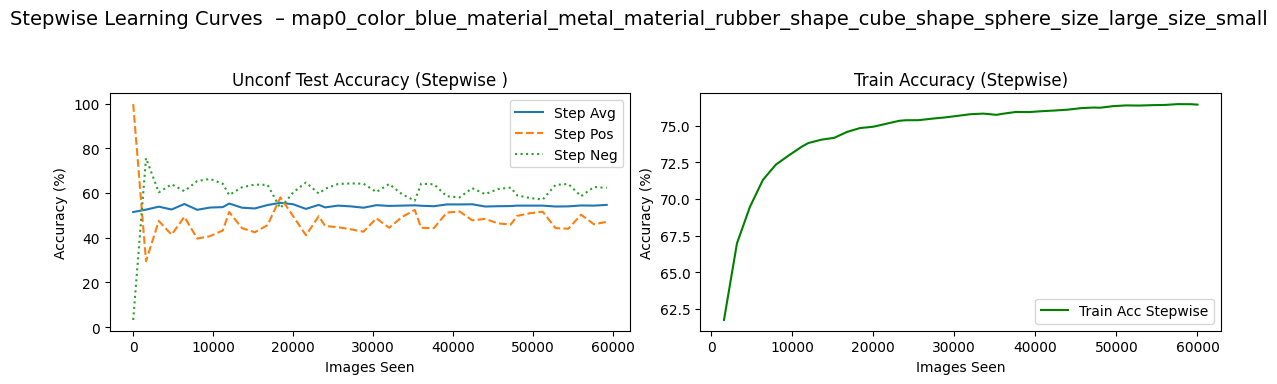

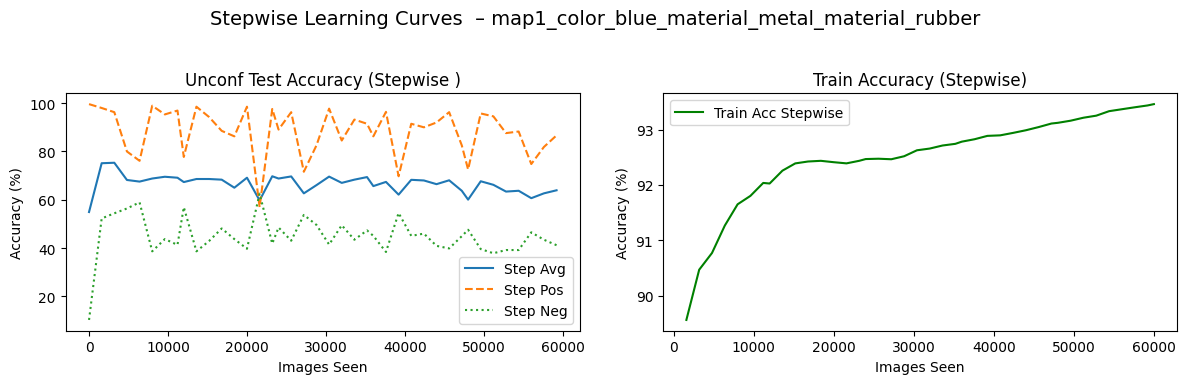

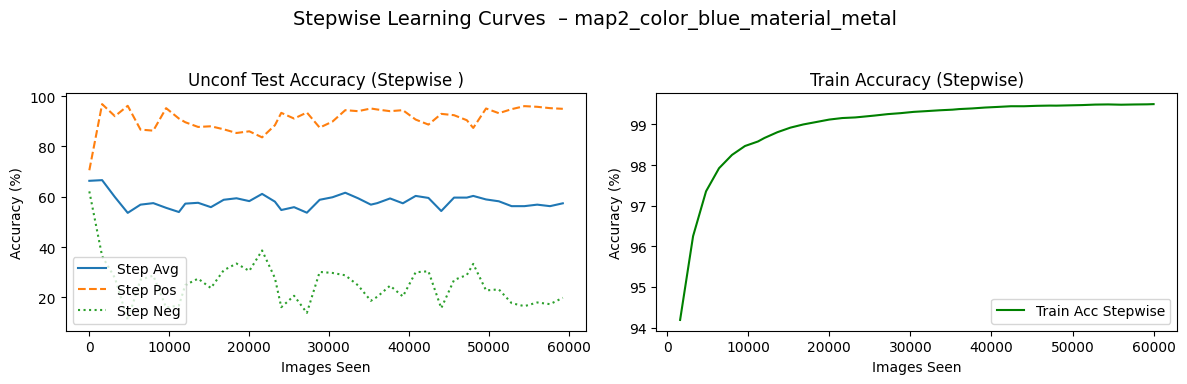

In [59]:
print_highest_stepwise_acc(res_1_1, frac=0.5)
plot_stepwise_zoom(res_1_1, frac=0.5) 

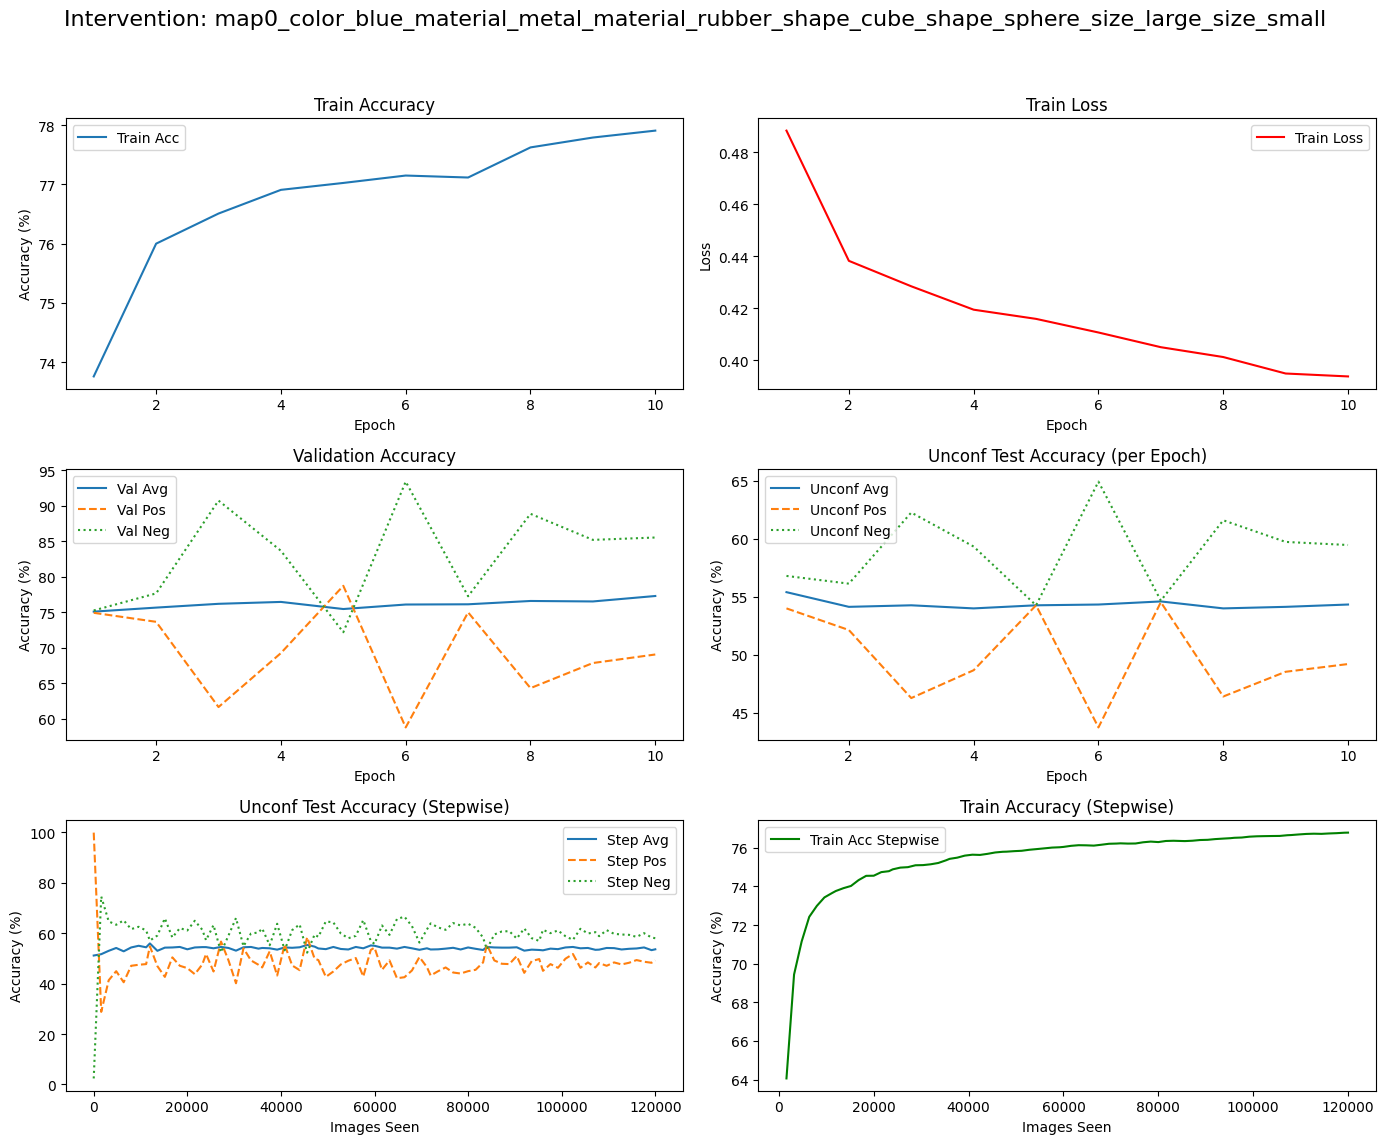

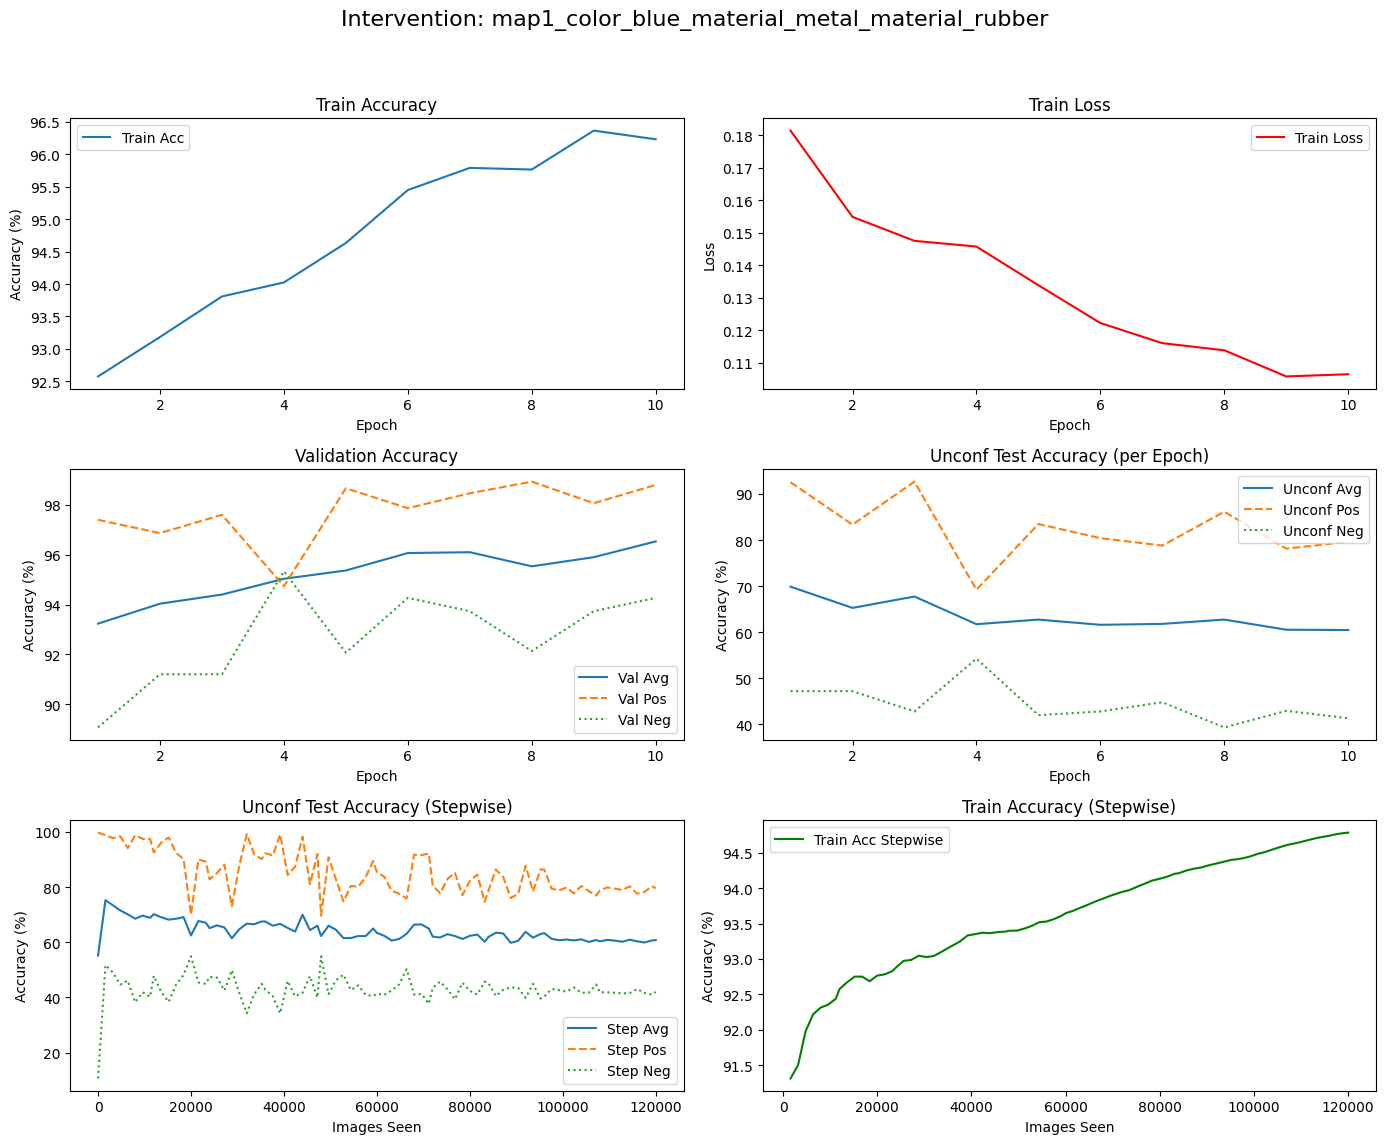

In [41]:
plot_training_results(res_1)

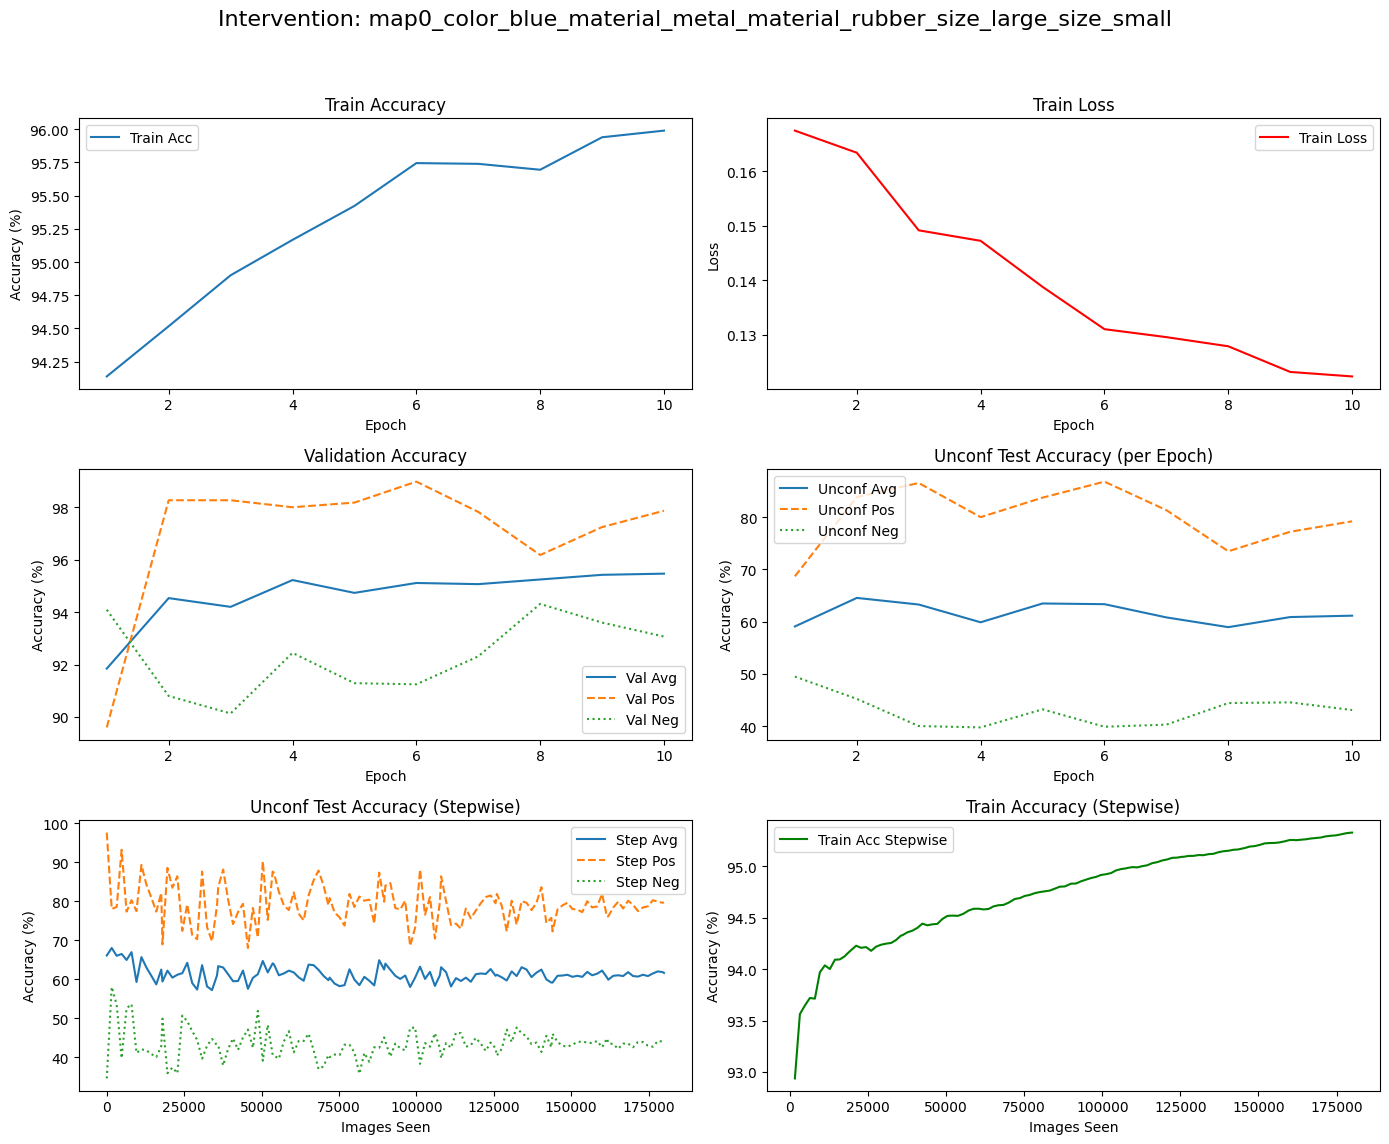

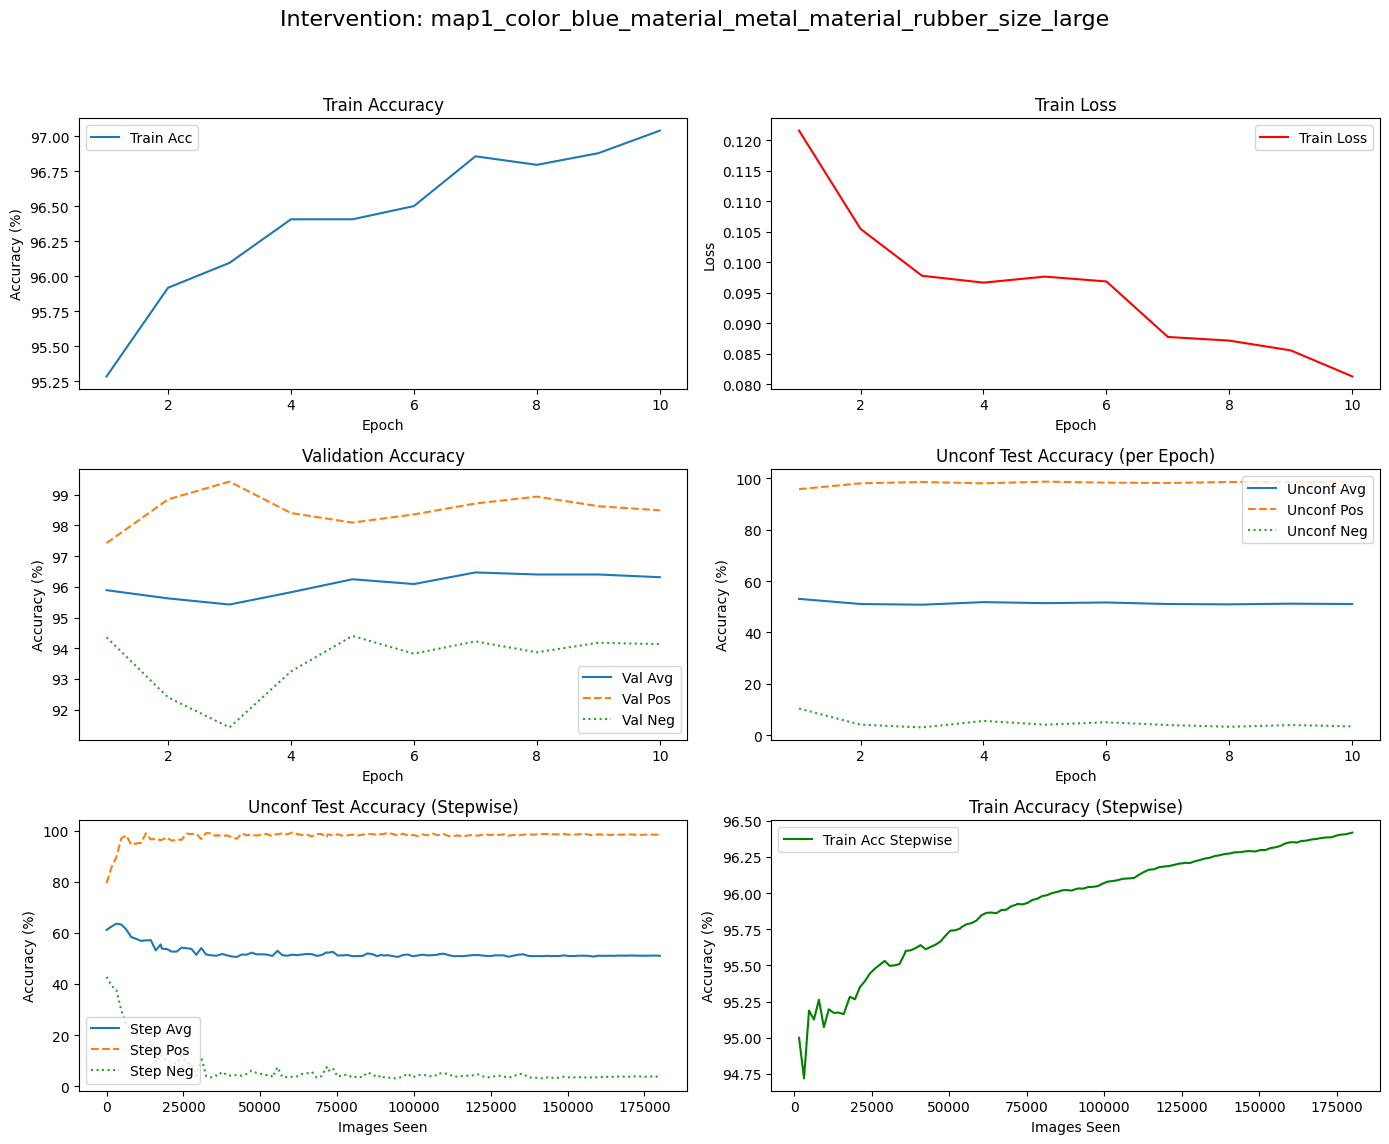

In [46]:
plot_training_results(res_2)

In [35]:
def evaluate_collect_attr(
    model, loader_p, loader_n,
    attr_indices, attr_labels, device):

    model.eval()
    correct_p = correct_n = 0
    total_p = total_n = 0
    sym_p, preds_p = [], []
    sym_n, preds_n = [], []

    # Store per-batch accuracy
    batch_acc_p, batch_acc_n = [], []

    with torch.no_grad():
        for loader, is_pos, correct, batch_acc, total in [
            (loader_p, True, 0, batch_acc_p, total_p),
            (loader_n, False, 0, batch_acc_n, total_n),
        ]:
            for images, labels in loader:
                images = (images.to(device) - 0.5) * 2
                labels = labels.to(device)

                slots = model.img2state_net(images)
                attrs = model.img2state_net._transform_attrs(slots).detach()
                for idx in attr_indices:
                    attrs[..., idx] = 0

                out = model.set_cls(attrs)
                preds = out.argmax(1)
                correct_batch = (preds == labels).sum().item()
                total_batch = len(labels)
                acc_batch = 100. * correct_batch / total_batch

                # Save step-wise batch accuracy
                batch_acc.append(acc_batch)

                if is_pos:
                    correct_p += correct_batch
                    total_p += total_batch
                else:
                    correct_n += correct_batch
                    total_n += total_batch

                for i in range(images.size(0)):
                    sym_np = attrs[i].cpu().numpy().T  # [n_attrs, n_slots]
                    pred = int(preds[i].cpu())
                    if pred == 1:
                        sym_p.append(sym_np)
                        preds_p.append(pred)
                    else:
                        sym_n.append(sym_np)
                        preds_n.append(pred)

    acc_p = 100 * correct_p / total_p
    acc_n = 100 * correct_n / total_n
    acc_avg = 0.5 * (acc_p + acc_n)

    # Return batch-wise accuracy lists as well
    return acc_p, acc_n, acc_avg, sym_p, preds_p, sym_n, preds_n, batch_acc_p, batch_acc_n


Unconf‐avg: 50.9%  (pos 99.5, neg 2.3)
#️⃣ Number of positive predictions: 1479
#️⃣ Number of negative predictions: 21


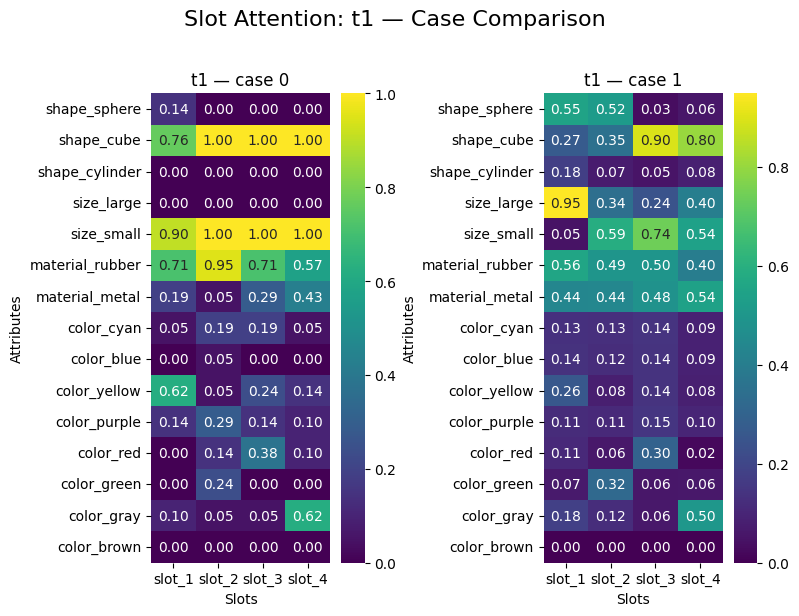

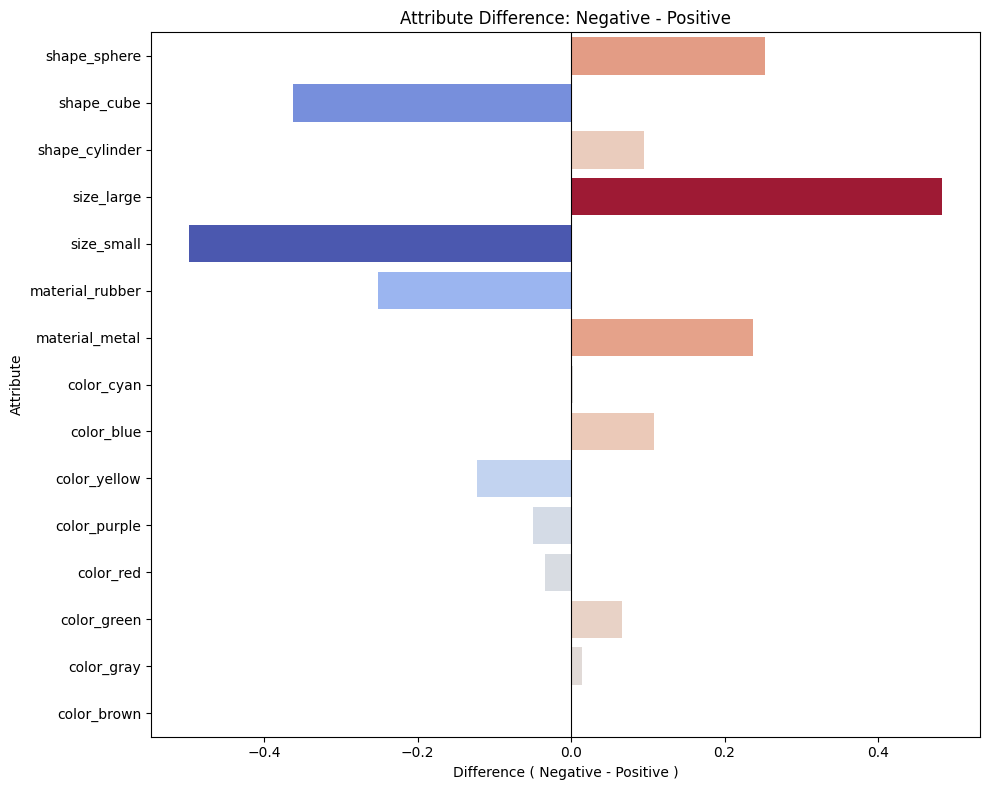

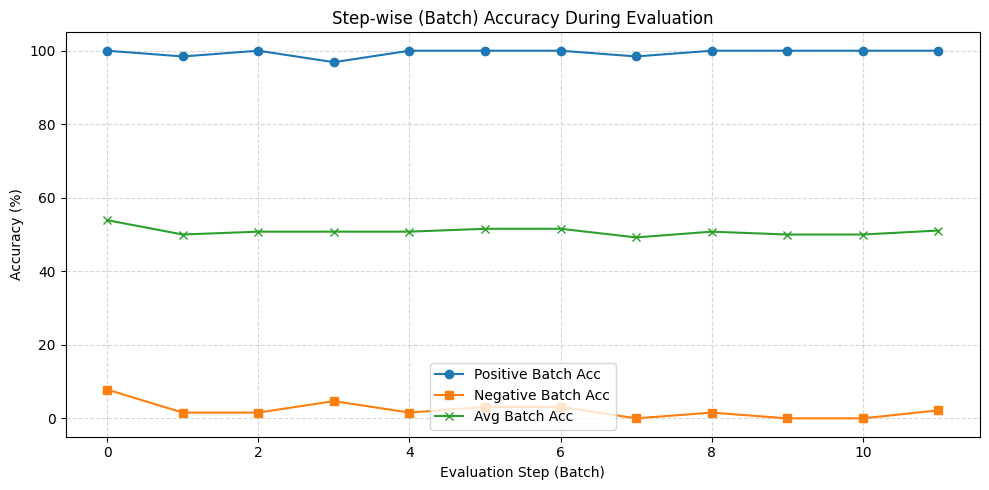

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# —————————————————————————————————————————————
# 1) Evaluate & collect per‐example symbolic slots + preds
# —————————————————————————————————————————————

path = "/workspaces/src/train_files/models_test1/model_task1_color_blue_material_metal_material_rubber.pt"
model_test = NeSyConceptLearner(
        n_classes=2,
        n_slots=10,
        n_iters=3,
        n_attr=18,
        n_set_heads=4,
        set_transf_hidden=128,
        category_ids=[3, 6, 8, 10, 17],
        device='cuda'
    ).to('cuda')

model_test.load_state_dict(torch.load(path, map_location='cuda'))
model_test.eval()





# —————————————————————————————————————————————
# 5) Putting it all together
# —————————————————————————————————————————————

attr_indices = []        # whatever your current intervention
acc_p, acc_n, acc_avg, \
sym_p, preds_p, \
sym_n, preds_n, \
batch_acc_p, batch_acc_n = evaluate_collect_attr(
    model_test,
    loader_unconf_p, loader_unconf_n,
    attr_indices, attr_labels,
    device='cuda'
)
print(f"Unconf‐avg: {acc_avg:.1f}%  (pos {acc_p:.1f}, neg {acc_n:.1f})")

# first compute your reference prototype:
clean_ref, clean_labels, slot_idx_ref = clean_symbolic_matrix(sym_p[0], attr_labels)

# now build aligned lists
aligned_p = []
for m in sym_p:
    mat, labs, idxs = clean_symbolic_matrix(m, attr_labels)
    assert labs == clean_labels, "Label mismatch!"
    aligned_p.append(
        match_slots(mat,     # the new example’s cleaned matrix
                    clean_ref,# your reference matrix
                    clean_labels)  # the common label ordering
    )

aligned_n = []
for m in sym_n:
    mat, labs, idxs = clean_symbolic_matrix(m, attr_labels)
    assert labs == clean_labels
    aligned_n.append(match_slots(mat, clean_ref, clean_labels))

print(f"#️⃣ Number of positive predictions: {len(aligned_p)}")
proto_p = build_prototype(aligned_p)

print(f"#️⃣ Number of negative predictions: {len(aligned_n)}")
proto_n = build_prototype(aligned_n)
# plot
plot_case_comparison(
    task="t1",
    merged_matrices=[ proto_n, proto_p ],
    clean_attr_labels=clean_attr_labels
)
mean_p = proto_p.mean(axis=1)   # [n_attr]
mean_n = proto_n.mean(axis=1)   # [n_attr]
diff = mean_p - mean_n          # [n_attr]

# Optionally, you can flip sign or direction depending on your interpretation
# For example: diff = mean_n - mean_p

# Build dataframe for plotting
df_diff = pd.DataFrame({
    'Attribute': clean_attr_labels,
    'Difference': diff
})

plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_diff, 
    y='Attribute', x='Difference',  # y=attributes, x=difference
    palette="coolwarm", hue='Difference', dodge=False
)
plt.title("Attribute Difference: Negative - Positive")
plt.xlabel("Difference ( Negative - Positive )")
plt.ylabel("Attribute")
plt.axvline(0, color='black', linewidth=0.8)
plt.legend([],[], frameon=False)  # Remove redundant legend
plt.tight_layout()
plt.show()
batch_acc_p = np.array(batch_acc_p)
batch_acc_n = np.array(batch_acc_n)
batch_acc_avg = 0.5 * (batch_acc_p + batch_acc_n)

plt.figure(figsize=(10, 5))
plt.plot(batch_acc_p, label='Positive Batch Acc', marker='o')
plt.plot(batch_acc_n, label='Negative Batch Acc', marker='s')
plt.plot(batch_acc_avg, label='Avg Batch Acc', marker='x')
plt.xlabel('Evaluation Step (Batch)')
plt.ylabel('Accuracy (%)')
plt.title('Step-wise (Batch) Accuracy During Evaluation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




Unconf‐avg: 51.0%  (pos 98.4, neg 3.6)
#️⃣ Number of positive predictions: 1461
#️⃣ Number of negative predictions: 39


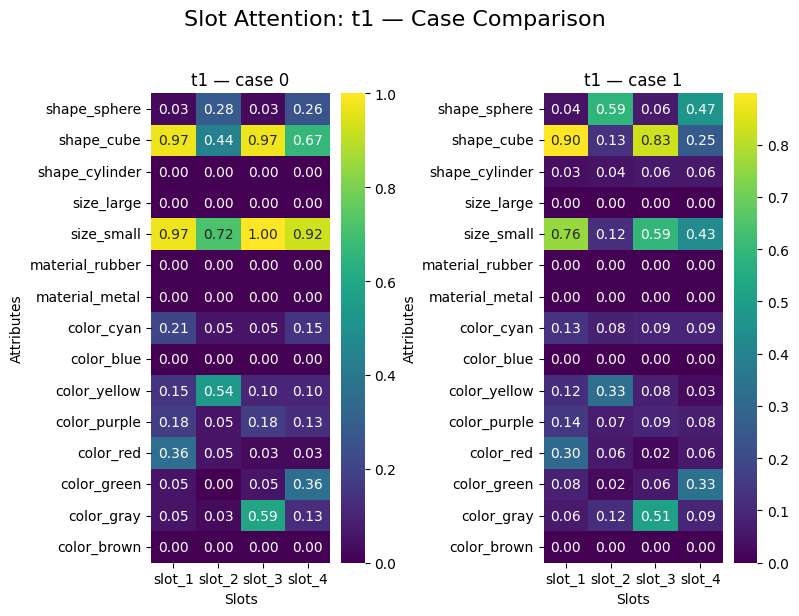

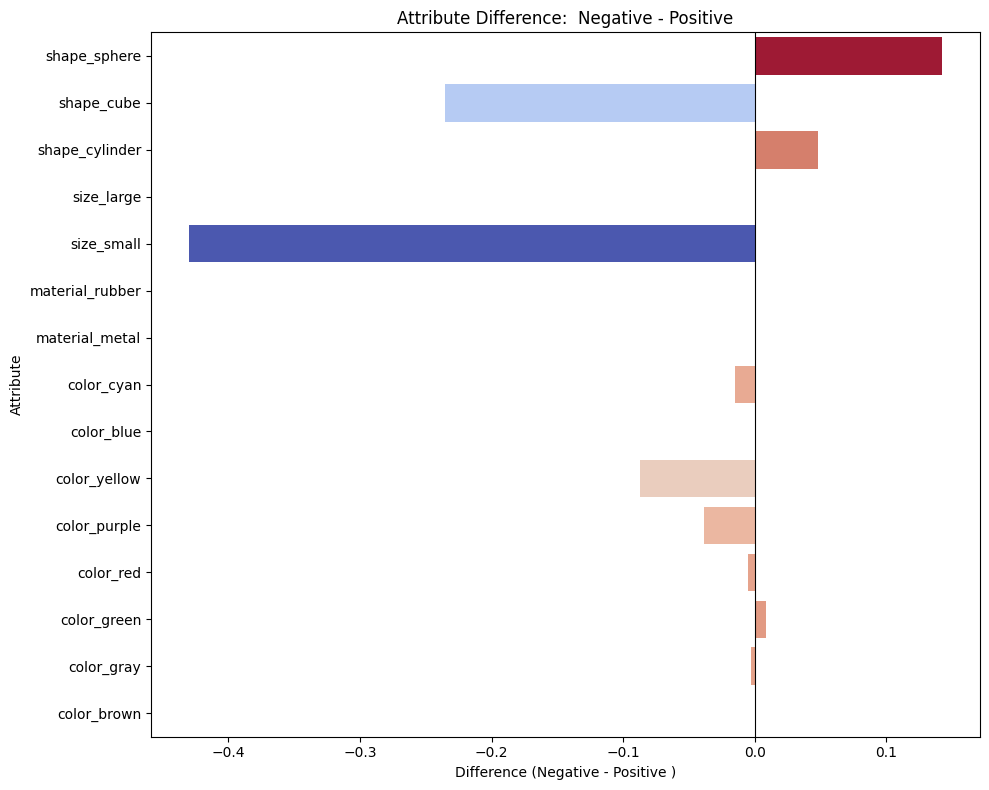

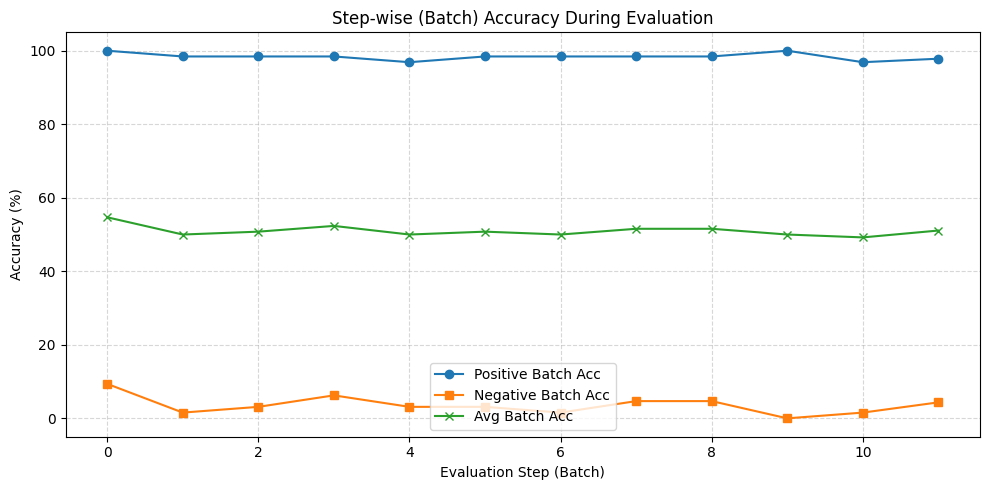

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# —————————————————————————————————————————————
# 1) Evaluate & collect per‐example symbolic slots + preds
# —————————————————————————————————————————————
path = "/workspaces/src/train_files/models_test2/model_task1_color_blue_material_metal_material_rubber_color_blue_material_metal_material_rubber_size_large.pt"
model_t1 = NeSyConceptLearner(
        n_classes=2,
        n_slots=10,
        n_iters=3,
        n_attr=18,
        n_set_heads=4,
        set_transf_hidden=128,
        category_ids=[3, 6, 8, 10, 17],
        device='cuda'
    ).to('cuda')

model_t1.load_state_dict(torch.load(path, map_location='cuda'))
model_t1.eval()





# —————————————————————————————————————————————
# 5) Putting it all together
# —————————————————————————————————————————————

attr_indices = [attr_labels.index("color_blue"),attr_labels.index("material_metal"),attr_labels.index("material_rubber"),attr_labels.index("size_large")]        # whatever your current intervention
acc_p, acc_n, acc_avg, \
sym_p, preds_p, \
sym_n, preds_n, \
batch_acc_p, batch_acc_n = evaluate_collect_attr(
    model_t1,
    loader_unconf_p, loader_unconf_n,
    attr_indices, attr_labels,
    device='cuda'
)
print(f"Unconf‐avg: {acc_avg:.1f}%  (pos {acc_p:.1f}, neg {acc_n:.1f})")

# first compute your reference prototype:
clean_ref, clean_labels, slot_idx_ref = clean_symbolic_matrix(sym_p[0], attr_labels)

# now build aligned lists
aligned_p = []
for m in sym_p:
    mat, labs, idxs = clean_symbolic_matrix(m, attr_labels)
    assert labs == clean_labels, "Label mismatch!"
    aligned_p.append(
        match_slots(mat,     # the new example’s cleaned matrix
                    clean_ref,# your reference matrix
                    clean_labels)  # the common label ordering
    )

aligned_n = []
for m in sym_n:
    mat, labs, idxs = clean_symbolic_matrix(m, attr_labels)
    assert labs == clean_labels
    aligned_n.append(match_slots(mat, clean_ref, clean_labels))

print(f"#️⃣ Number of positive predictions: {len(aligned_p)}")
proto_p = build_prototype(aligned_p)

print(f"#️⃣ Number of negative predictions: {len(aligned_n)}")
proto_n = build_prototype(aligned_n)
# plot
plot_case_comparison(
    task="t1",
    merged_matrices=[proto_n,proto_p],
    clean_attr_labels=clean_attr_labels
)

mean_p = proto_p.mean(axis=1)   # [n_attr]
mean_n = proto_n.mean(axis=1)   # [n_attr]
diff = mean_p - mean_n          # [n_attr]


# Optionally, you can flip sign or direction depending on your interpretation
# For example: diff = mean_n - mean_p

# Build dataframe for plotting
df_diff = pd.DataFrame({
    'Attribute': clean_attr_labels,
    'Difference': diff
})

plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_diff, 
    y='Attribute', x='Difference',  # y=attributes, x=difference
    palette="coolwarm", hue='Difference', dodge=False
)
plt.title("Attribute Difference:  Negative - Positive")
plt.xlabel("Difference (Negative - Positive )")
plt.ylabel("Attribute")
plt.axvline(0, color='black', linewidth=0.8)
plt.legend([],[], frameon=False)  # Remove redundant legend
plt.tight_layout()
plt.show()


batch_acc_p = np.array(batch_acc_p)
batch_acc_n = np.array(batch_acc_n)
batch_acc_avg = 0.5 * (batch_acc_p + batch_acc_n)

plt.figure(figsize=(10, 5))
plt.plot(batch_acc_p, label='Positive Batch Acc', marker='o')
plt.plot(batch_acc_n, label='Negative Batch Acc', marker='s')
plt.plot(batch_acc_avg, label='Avg Batch Acc', marker='x')
plt.xlabel('Evaluation Step (Batch)')
plt.ylabel('Accuracy (%)')
plt.title('Step-wise (Batch) Accuracy During Evaluation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




Model t1: Unconfounded Acc: 50.80% (Pos: 99.60%, Neg: 2.00%)
Blue + Metal - Task 1: Unconfounded Acc: 56.20% (Pos: 93.73%, Neg: 18.67%)
Blue + Metal + Rubber - Task 1: Unconfounded Acc: 63.40% (Pos: 84.80%, Neg: 42.00%)
BMR + (BMR_T1-Large-Small) - Task 2: Unconfounded Acc: 59.13% (Pos: 74.27%, Neg: 44.00%)
BMR + (BMR_T1 + Large) - Task 2: Unconfounded Acc: 51.13% (Pos: 98.27%, Neg: 4.00%)


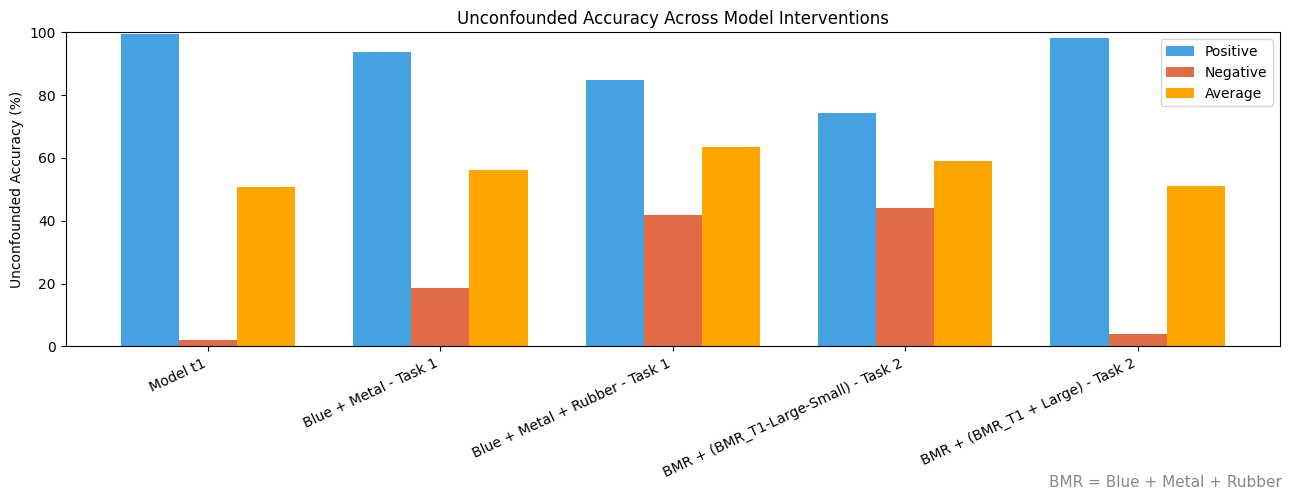

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# model_runs = [
#     ("/workspaces/src/train_files/models_test1_1/model_task1_color_blue_material_metal_material_rubber_shape_cube_shape_sphere_size_large_size_small.pt",
#       ['color_blue','material_metal','size_large','shape_cube','size_small','shape_sphere','material_rubber'], 
#       "Remove Confounder + GT + Rubber"),
#     ("/workspaces/src/train_files/models_test1/model_task1_color_blue_material_metal_material_rubber.pt", 
#      ['color_blue', 'material_metal','material_rubber'], "Blue + Metal + Rubber - Task 1"),
#     ("/workspaces/src/train_files/models_test2/model_task1_color_blue_material_metal_material_rubber_color_blue_material_metal_material_rubber_size_large_size_small.pt", 
#      ['color_blue', 'material_metal','material_rubber'], "BMR + (BMR_T1-Large-Small) - Task 2"),
#       ("/workspaces/src/train_files/models_test2/model_task1_color_blue_material_metal_material_rubber_color_blue_material_metal_material_rubber_size_large.pt", 
#      ['color_blue', 'material_metal','material_rubber'], "BMR + (BMR_T1 + Large) - Task 2"),
# ]

model_runs = [
    ("/workspaces/src/checkpoints/model_task2.pt",
      [], 
      "Model t1"),
    ("/workspaces/src/train_files/models_test1_1/model_task1_color_blue_material_metal.pt",
      ['color_blue','material_metal'], 
      "Blue + Metal - Task 1"),
    ("/workspaces/src/train_files/models_test1_1/model_task1_color_blue_material_metal_material_rubber.pt", 
     ['color_blue', 'material_metal','material_rubber'], "Blue + Metal + Rubber - Task 1"),
    ("/workspaces/src/train_files/models_test2/model_task1_color_blue_material_metal_material_rubber_color_blue_material_metal_material_rubber_size_large_size_small.pt", 
     ['color_blue', 'material_metal','material_rubber'], "BMR + (BMR_T1-Large-Small) - Task 2"),
      ("/workspaces/src/train_files/models_test2/model_task1_color_blue_material_metal_material_rubber_color_blue_material_metal_material_rubber_size_large.pt", 
     ['color_blue', 'material_metal','material_rubber'], "BMR + (BMR_T1 + Large) - Task 2"),
]

labels = []
acc_list = []
acc_p_list = []
acc_n_list = []

for path, intervene_attrs, run_label in model_runs:
    model = NeSyConceptLearner(
        n_classes=2,
        n_slots=10,
        n_iters=3,
        n_attr=18,
        n_set_heads=4,
        set_transf_hidden=128,
        category_ids=[3, 6, 8, 10, 17],
        device='cuda'
    ).to('cuda')
    model.load_state_dict(torch.load(path, map_location='cuda'))
    model.eval()

    attr_indices = [attr_labels.index(a) for a in intervene_attrs]

    acc_p, acc_n, acc_avg, *_ = evaluate_collect_attr(
        model,
        loader_unconf_p, loader_unconf_n,
        attr_indices, attr_labels,
        device='cuda'
    )

    print(f"{run_label}: Unconfounded Acc: {acc_avg:.2f}% (Pos: {acc_p:.2f}%, Neg: {acc_n:.2f}%)")
    labels.append(run_label)
    acc_list.append(acc_avg)
    acc_p_list.append(acc_p)
    acc_n_list.append(acc_n)

# ---- Plot grouped bar chart ----
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(13, 5))
plt.bar(x - width, acc_p_list, width, label='Positive', color='#44a2e1')
plt.bar(x, acc_n_list, width, label='Negative', color='#e16b44')
plt.bar(x + width, acc_list, width, label='Average', color='orange')

plt.ylabel("Unconfounded Accuracy (%)")
plt.title("Unconfounded Accuracy Across Model Interventions")
plt.xticks(x, labels, rotation=25, ha='right')
plt.ylim(0, 100)
plt.legend()
plt.figtext(
    0.99, 0.01, "BMR = Blue + Metal + Rubber",
    ha="right", va="bottom", fontsize=11, color="#888"
)
plt.tight_layout()
plt.show()
